To ensure that every samples has GO annotations that represent a complete subgraph of the Gene Ontology, we'll leverage the hierarchical structure of the GO DAG to include terms of any missing descendants.

/home/andrew/Workspace/AmiGO/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 59089 examples [00:00, 647466.51 examples/s]


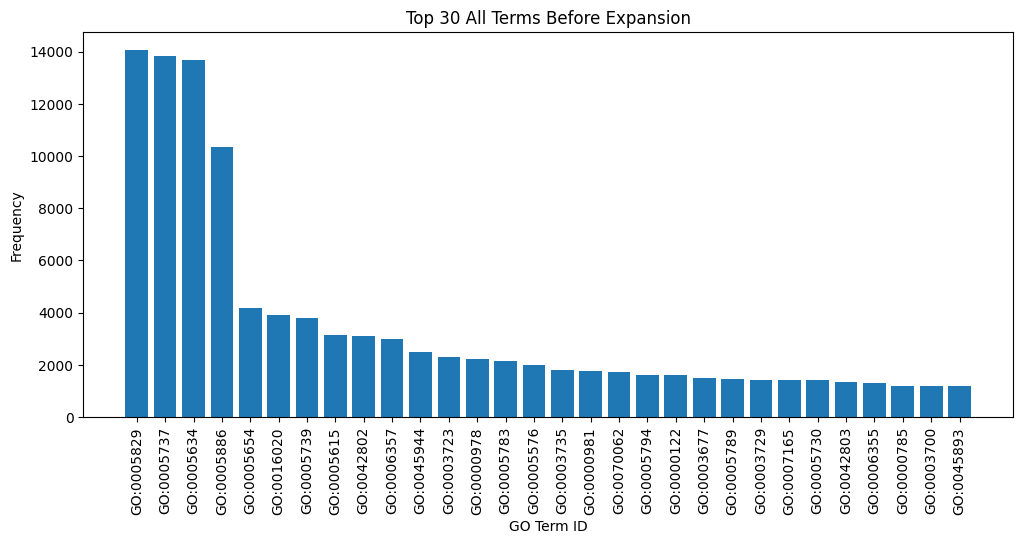

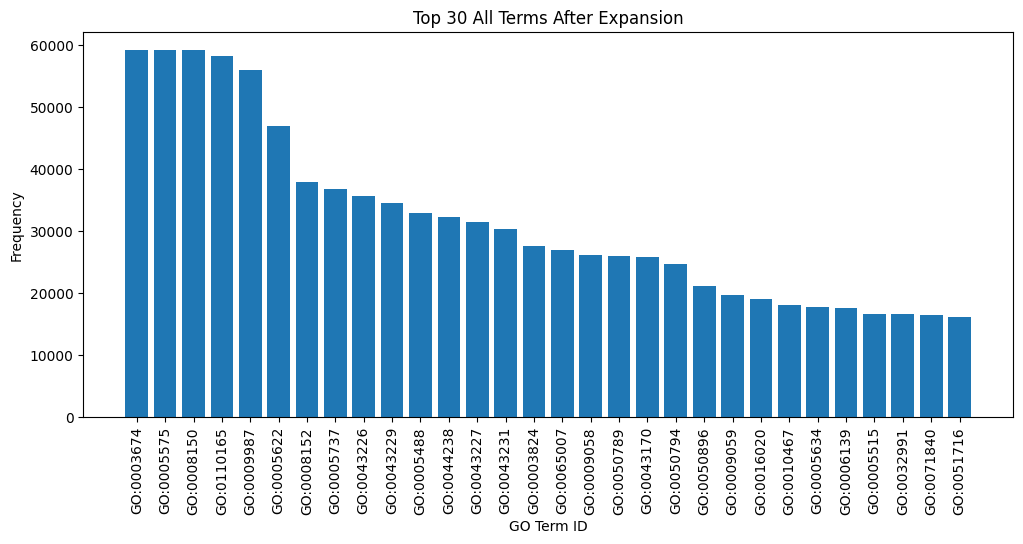

Total terms before/after: 518,755/3,952,707
Unique terms before/after: 24,358/28,086
Average terms before/after: 21.30/140.74


Dataset saved to ./dataset/all-expanded.jsonl


Generating train split: 89522 examples [00:00, 856372.42 examples/s]


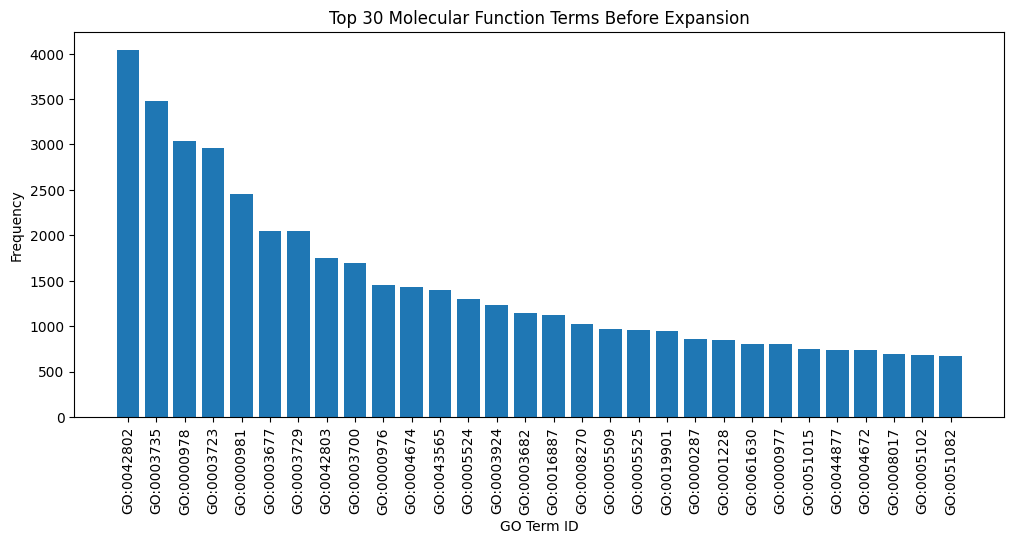

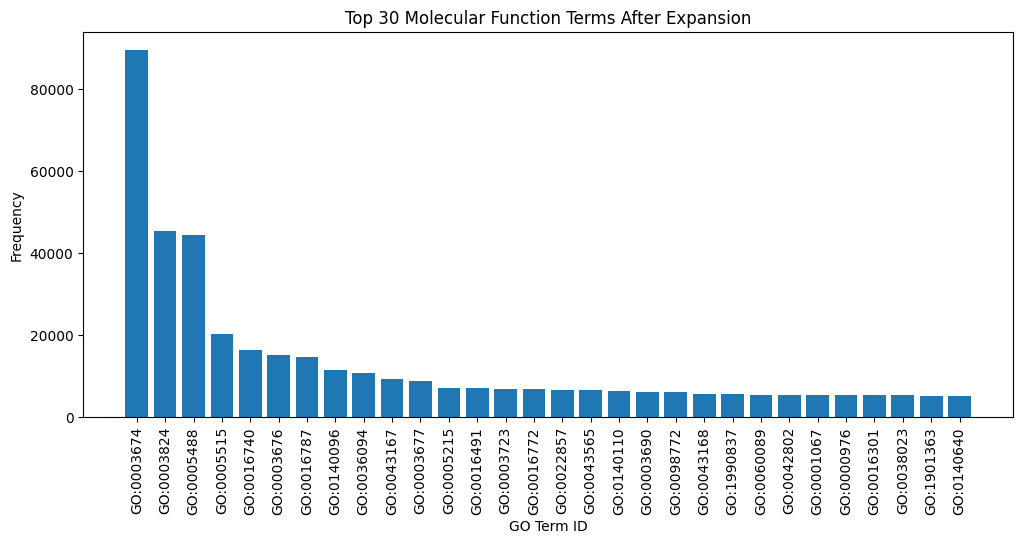

Total terms before/after: 165,367/910,275
Unique terms before/after: 6,891/7,195
Average terms before/after: 24.00/126.51


Dataset saved to ./dataset/mf-expanded.jsonl


Generating train split: 103470 examples [00:00, 889290.91 examples/s]


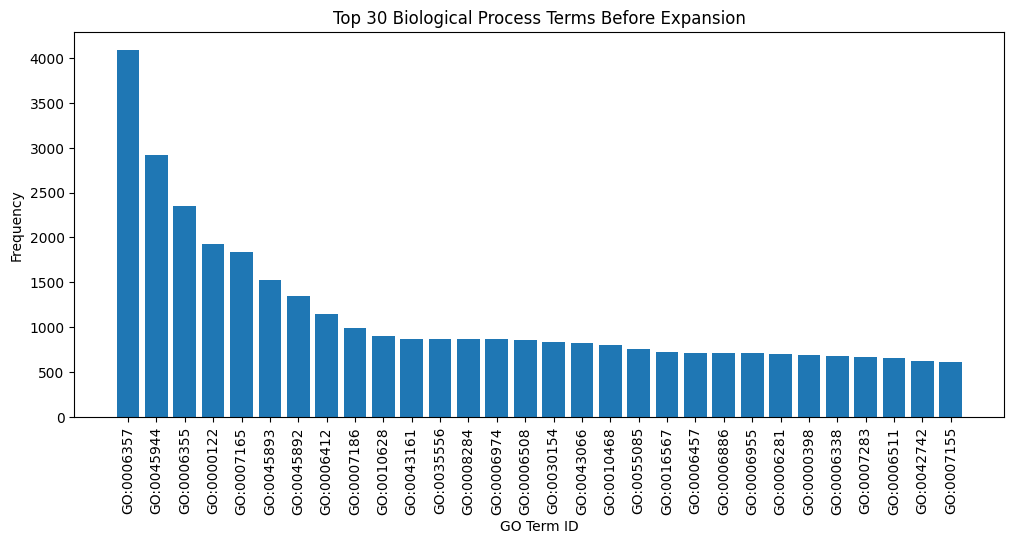

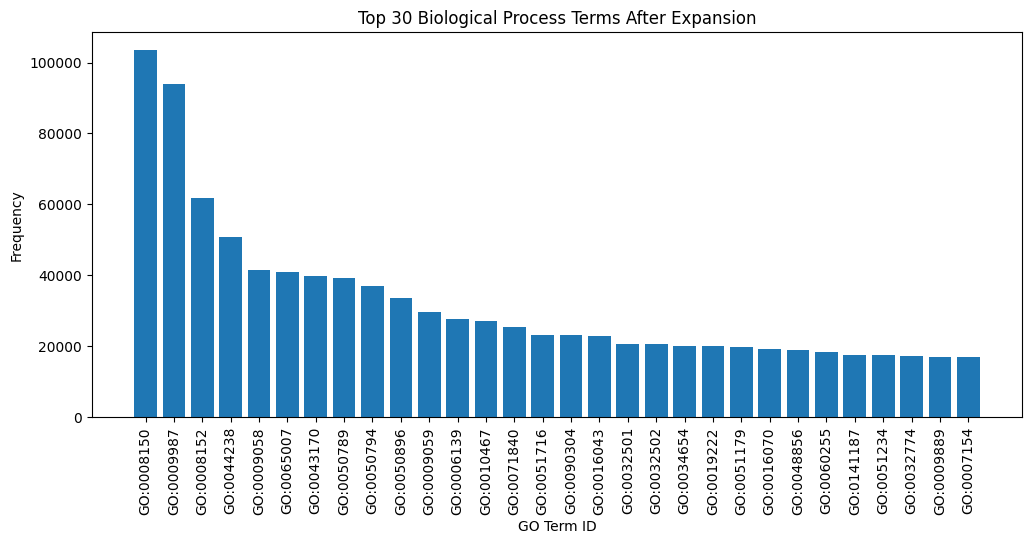

Total terms before/after: 340,122/3,682,421
Unique terms before/after: 17,161/20,149
Average terms before/after: 19.82/182.76


Dataset saved to ./dataset/bp-expanded.jsonl


Generating train split: 99954 examples [00:00, 953501.54 examples/s]


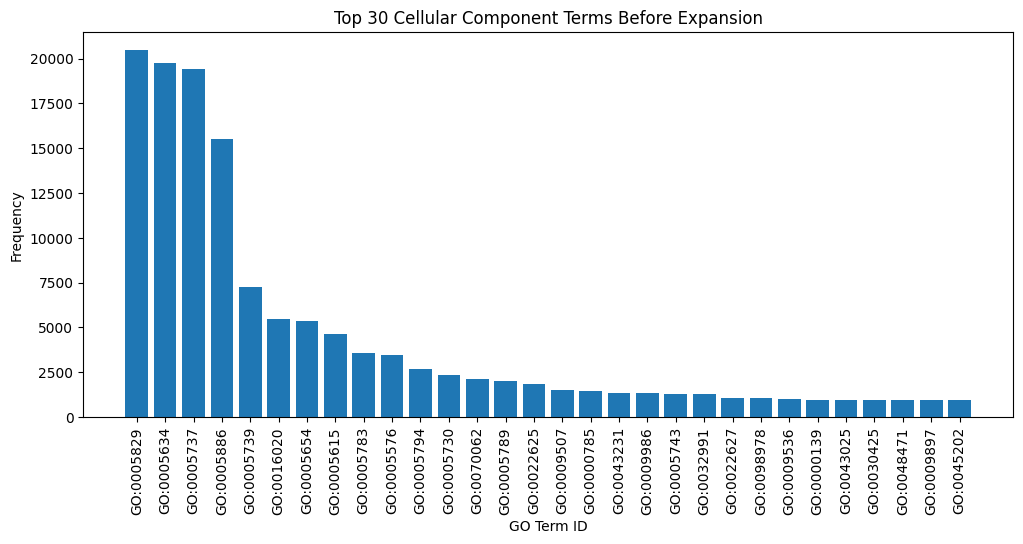

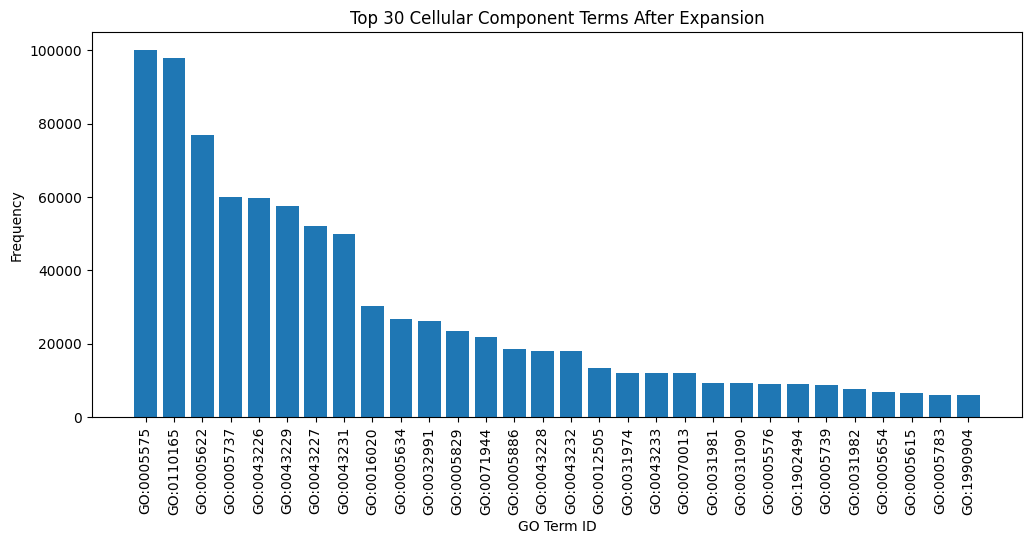

Total terms before/after: 226,906/1,250,123
Unique terms before/after: 2,742/2,921
Average terms before/after: 82.75/427.98


Dataset saved to ./dataset/cc-expanded.jsonl


In [1]:
from datasets import load_dataset

import obonet

import networkx as nx

from collections import Counter

from itertools import islice

import matplotlib.pyplot as plt

import json

all_dataset_path = "./dataset/all-filtered.jsonl"
mf_dataset_path = "./dataset/mf-filtered.jsonl"
bp_dataset_path = "./dataset/bp-filtered.jsonl"
cc_dataset_path = "./dataset/cc-filtered.jsonl"

all_expanded_path = "./dataset/all-expanded.jsonl"
mf_expanded_path = "./dataset/mf-expanded.jsonl"
bp_expanded_path = "./dataset/bp-expanded.jsonl"
cc_expanded_path = "./dataset/cc-expanded.jsonl"

top_k = 30

# Download the OBO file from https://geneontology.org/docs/download-ontology.
go_obo_path = "./dataset/go-basic.obo"

graph = obonet.read_obo(go_obo_path)

assert nx.is_directed_acyclic_graph(graph), "Invalid GO graph, use basic DAG."

for name, dataset_path, expanded_path in [
    ("All", all_dataset_path, all_expanded_path),
    ("Molecular Function", mf_dataset_path, mf_expanded_path),
    ("Biological Process", bp_dataset_path, bp_expanded_path),
    ("Cellular Component", cc_dataset_path, cc_expanded_path),
]:
    dataset = load_dataset("json", data_files=dataset_path, split="train")

    before_counter = Counter()
    after_counter = Counter()

    with open(expanded_path, "w") as file:
        for record in dataset:
            original_terms = set(record["go_terms"])

            expanded_terms = set()

            for node in original_terms:
                expanded_terms.add(node)

                for descendant in nx.descendants(graph, node):
                    expanded_terms.add(descendant)

            subgraph = graph.subgraph(expanded_terms)

            if not nx.is_directed_acyclic_graph(subgraph):
                print(f"Invalid subgraph for record {record['id']}, skipping.")
                
                continue

            for term in original_terms:
                before_counter[term] += 1

            for term in expanded_terms:
                after_counter[term] += 1
            
            record["go_terms"] = list(expanded_terms)

            file.write(json.dumps(record) + "\n")

    for when, counter, in (("Before", before_counter), ("After", after_counter)):
        counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

        first_k = dict(islice(counter.items(), top_k))

        plt.figure(figsize=(12, 5)) 

        plt.bar(first_k.keys(), first_k.values())

        plt.title(f"Top {top_k} {name} Terms {when} Expansion")
        plt.xticks(rotation=90)
        plt.xlabel("GO Term ID")
        plt.ylabel("Frequency")

        plt.show()

    total_before = before_counter.total()
    total_after = after_counter.total()

    unique_before = len(before_counter)
    unique_after = len(after_counter)

    average_before = total_before / unique_before
    average_after = total_after / unique_after

    print(f"Total terms before/after: {total_before:,}/{total_after:,}")
    print(f"Unique terms before/after: {unique_before:,}/{unique_after:,}")
    print(f"Average terms before/after: {average_before:.2f}/{average_after:.2f}")

    print("\n")

    print(f"Dataset saved to {expanded_path}")
                

Now let's plot a few subgraphs as a sanity check.

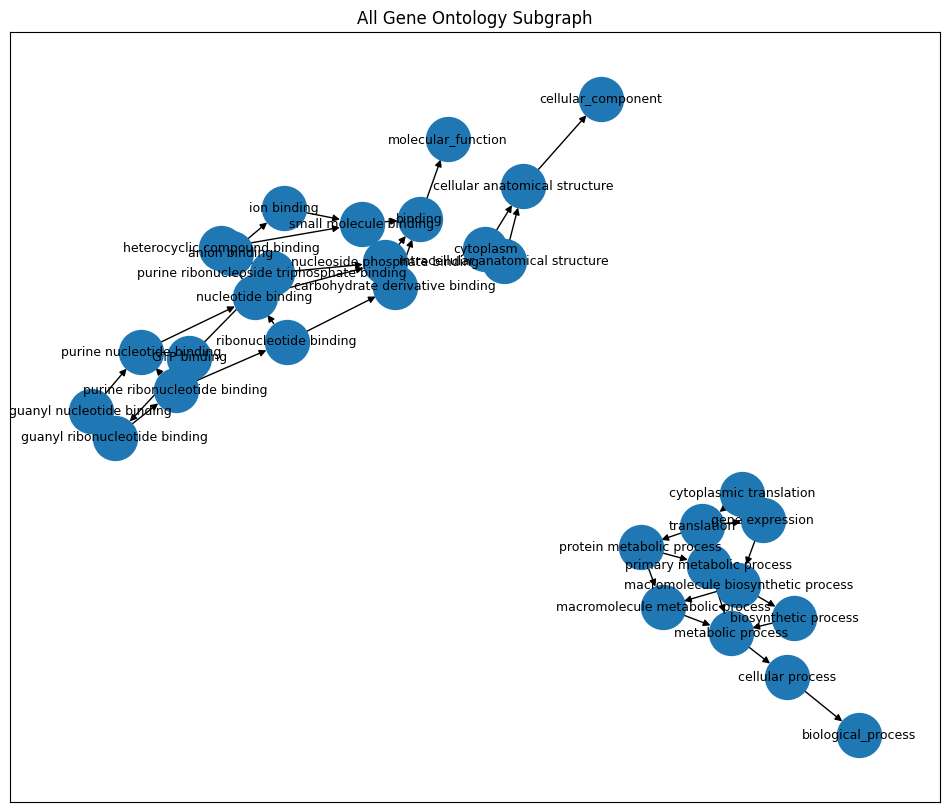

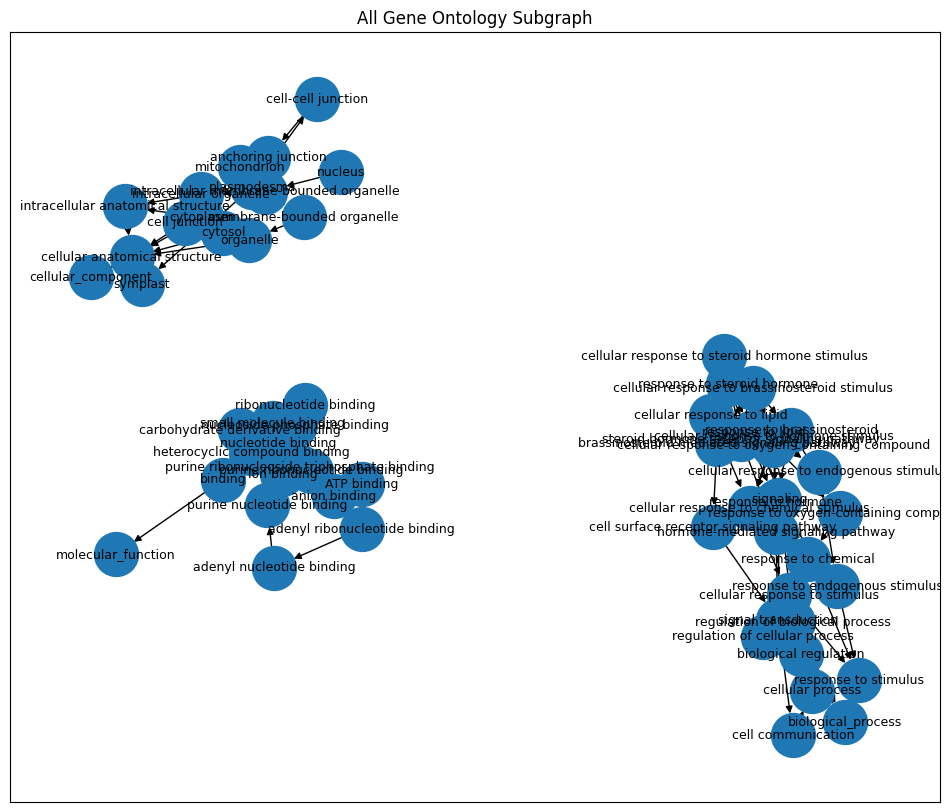

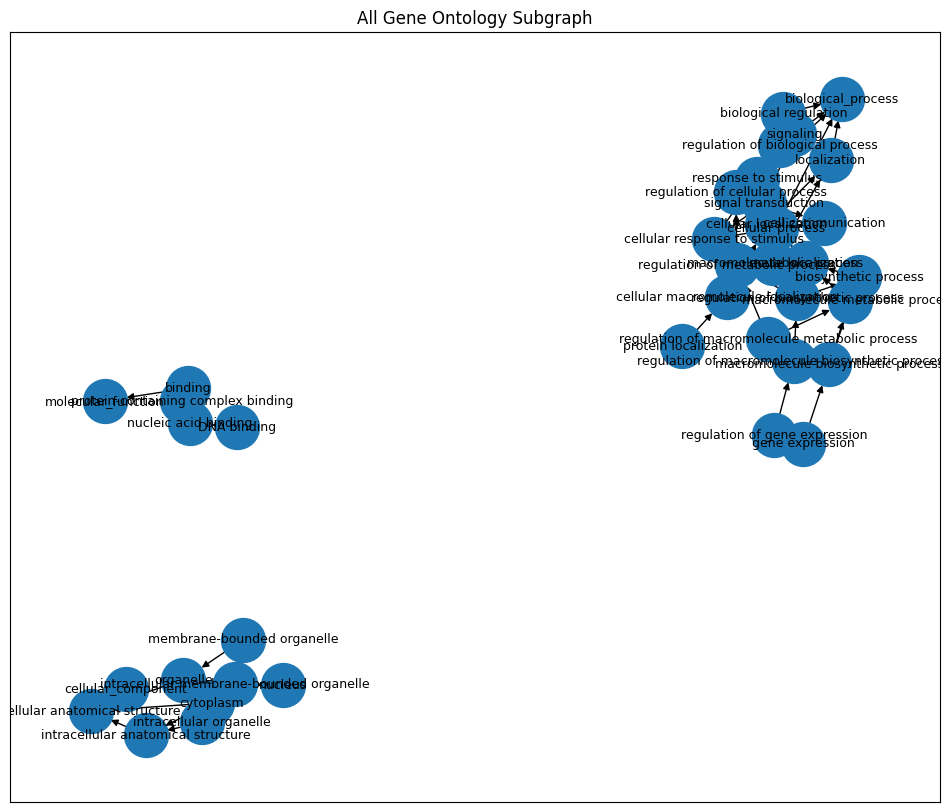

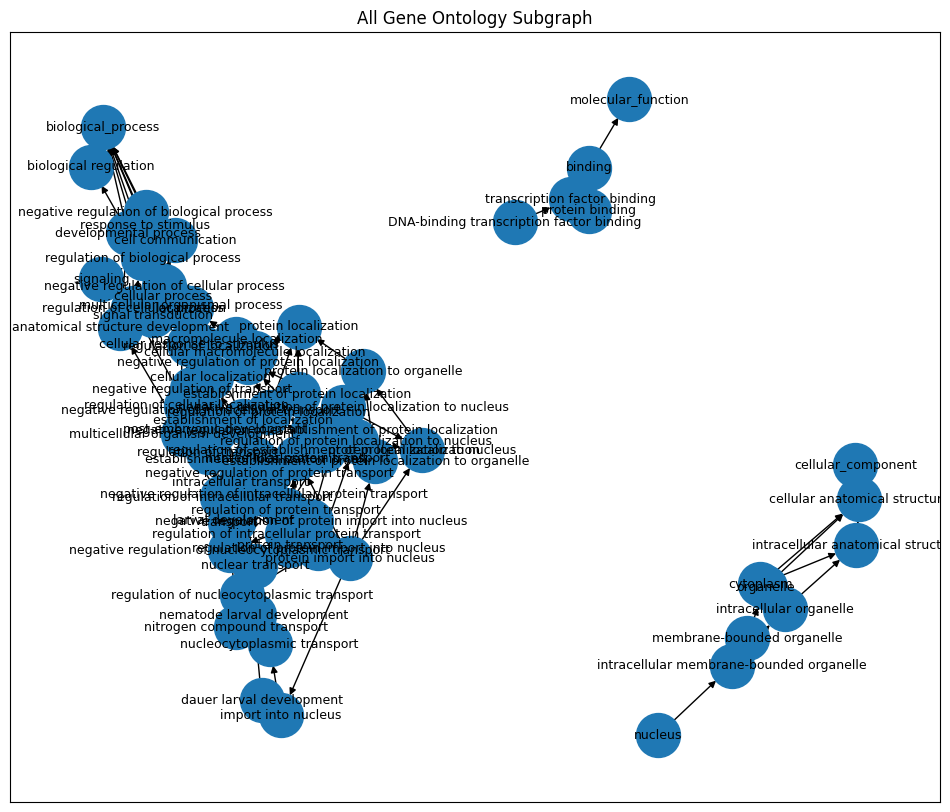

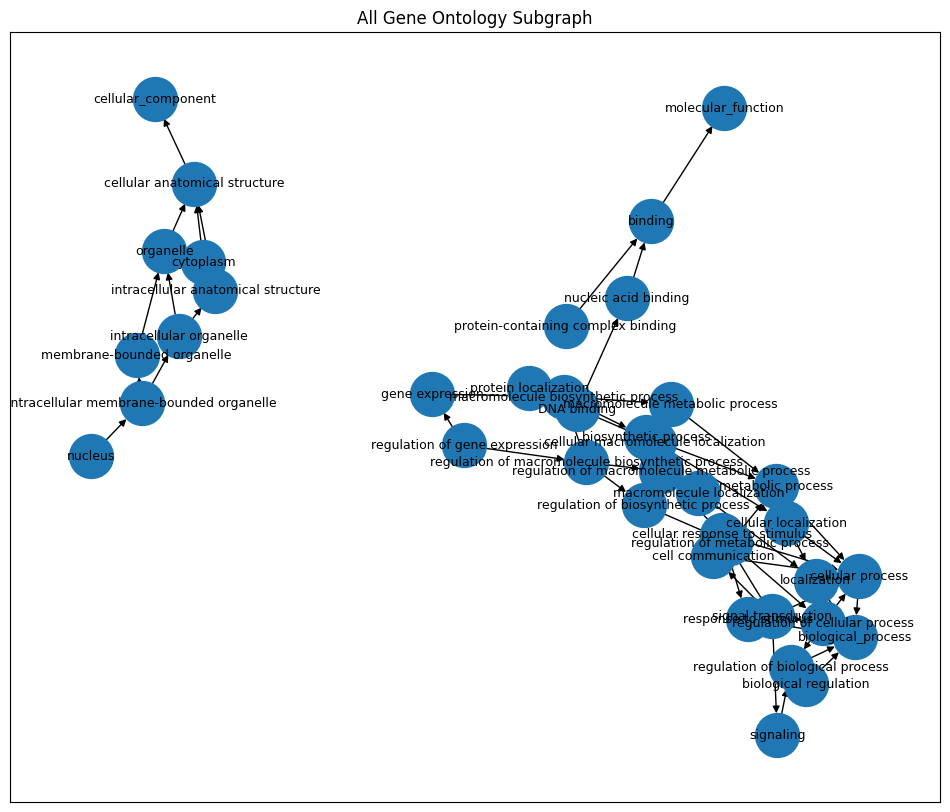

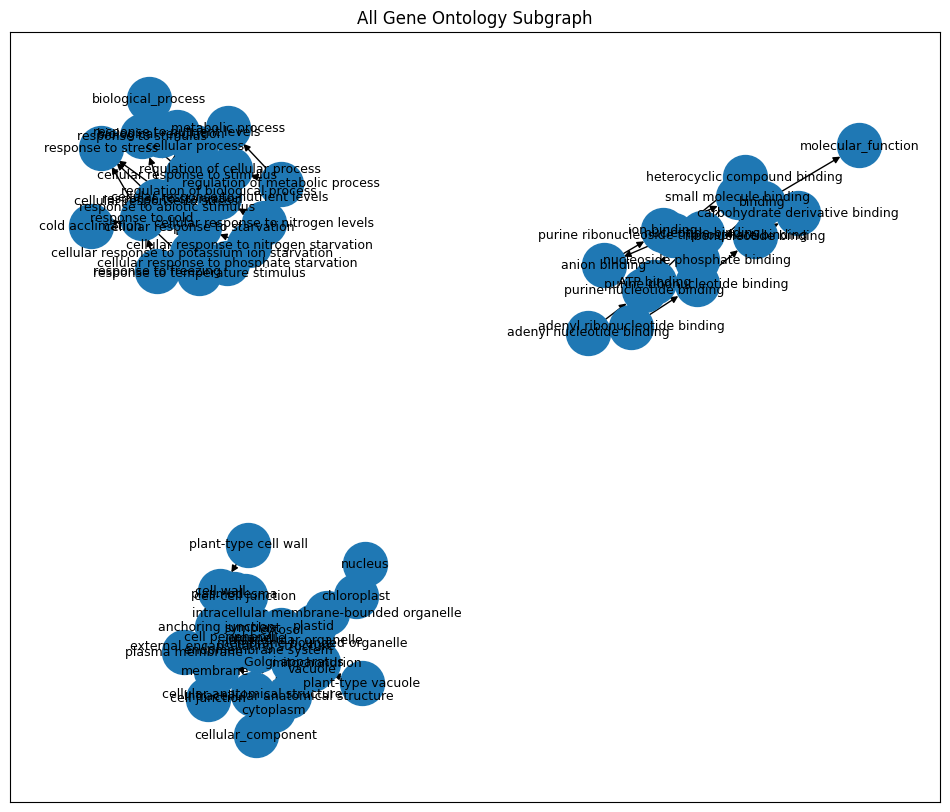

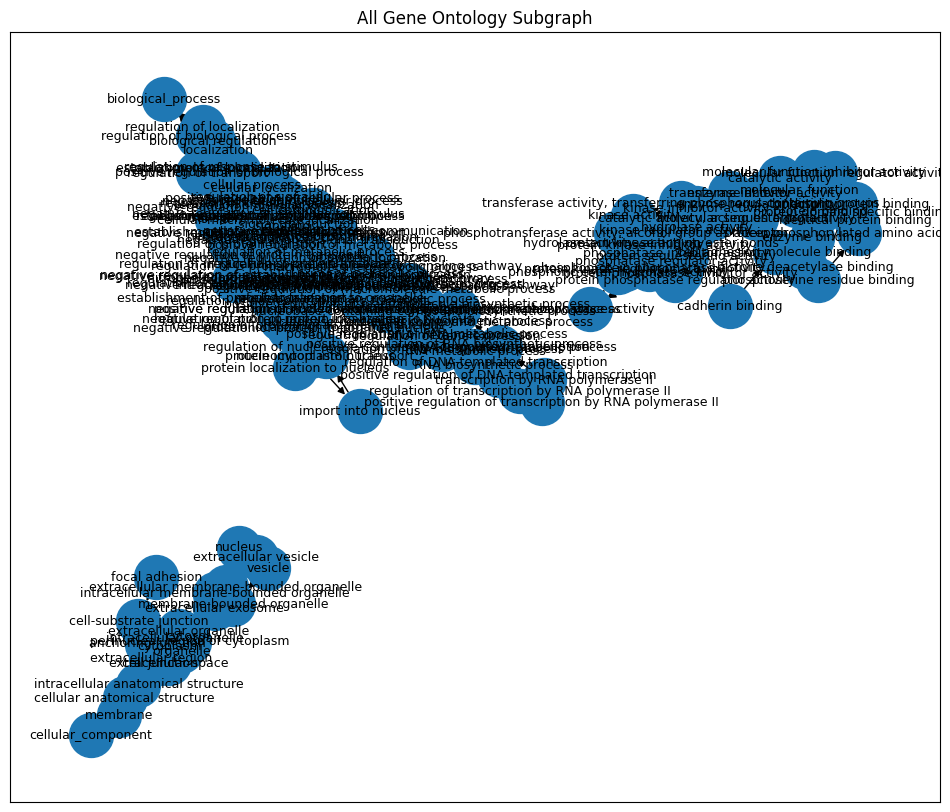

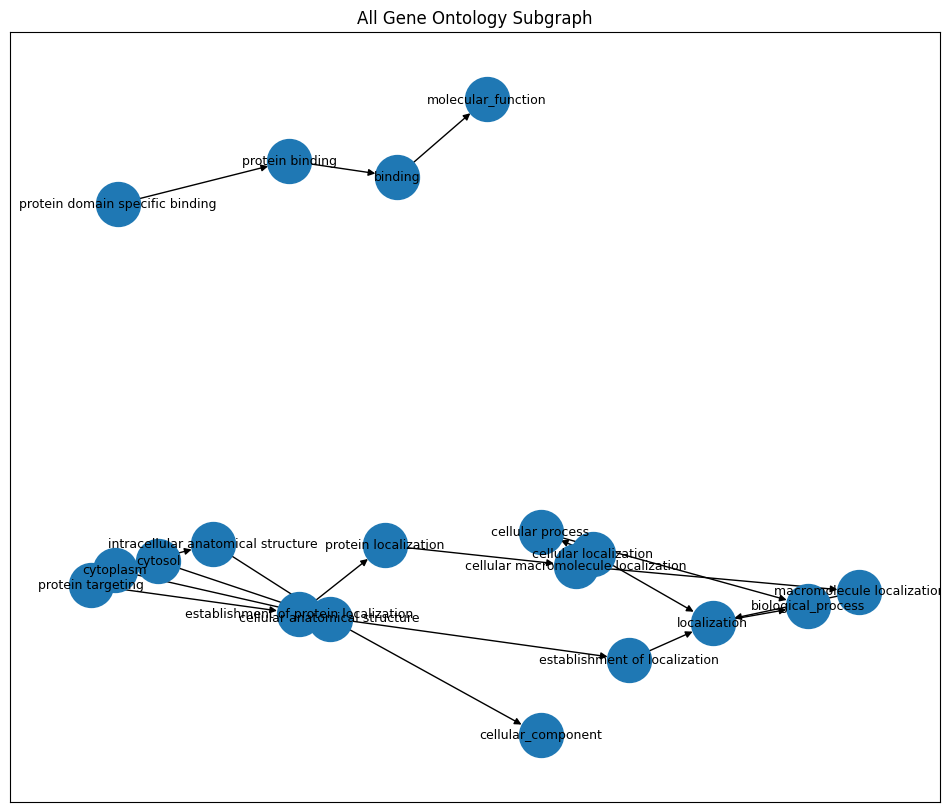

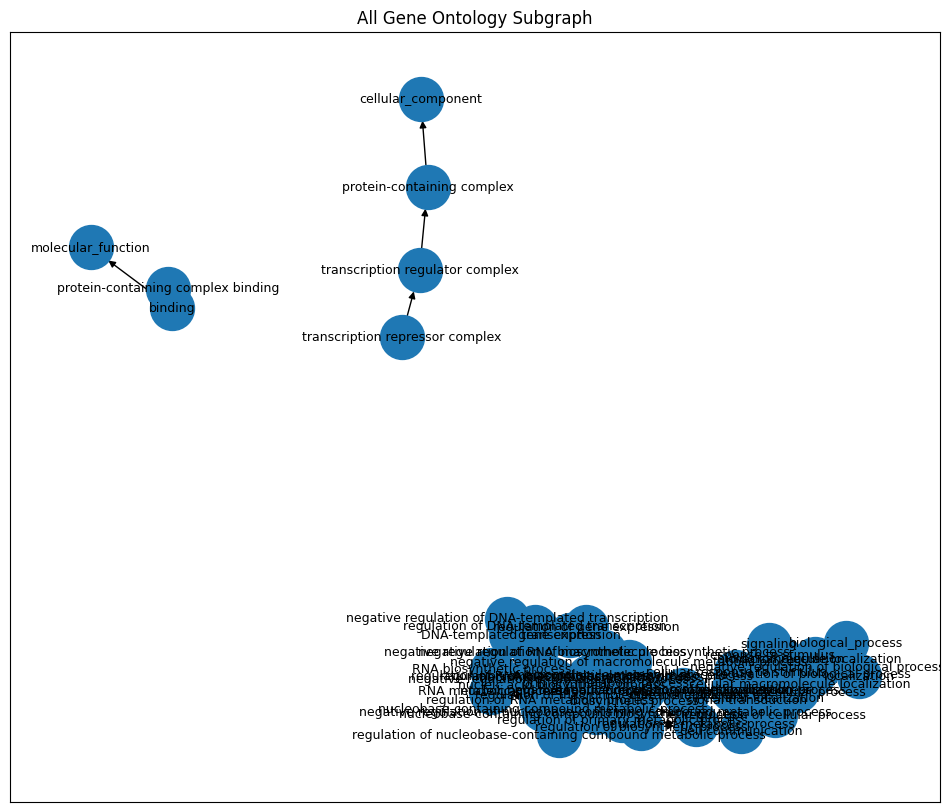

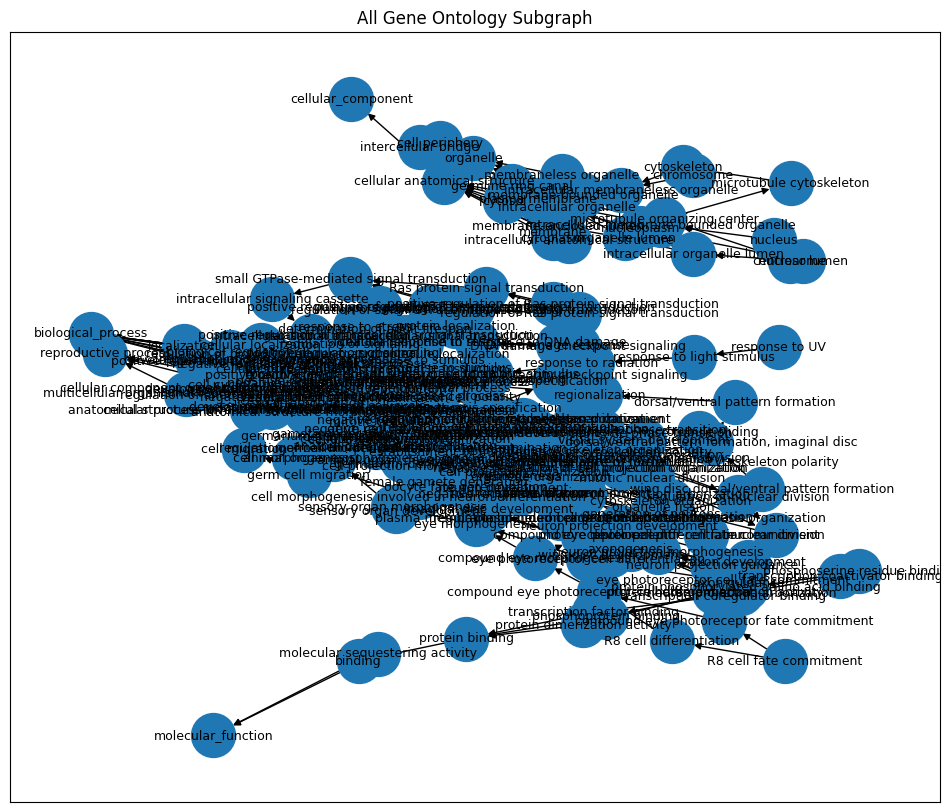

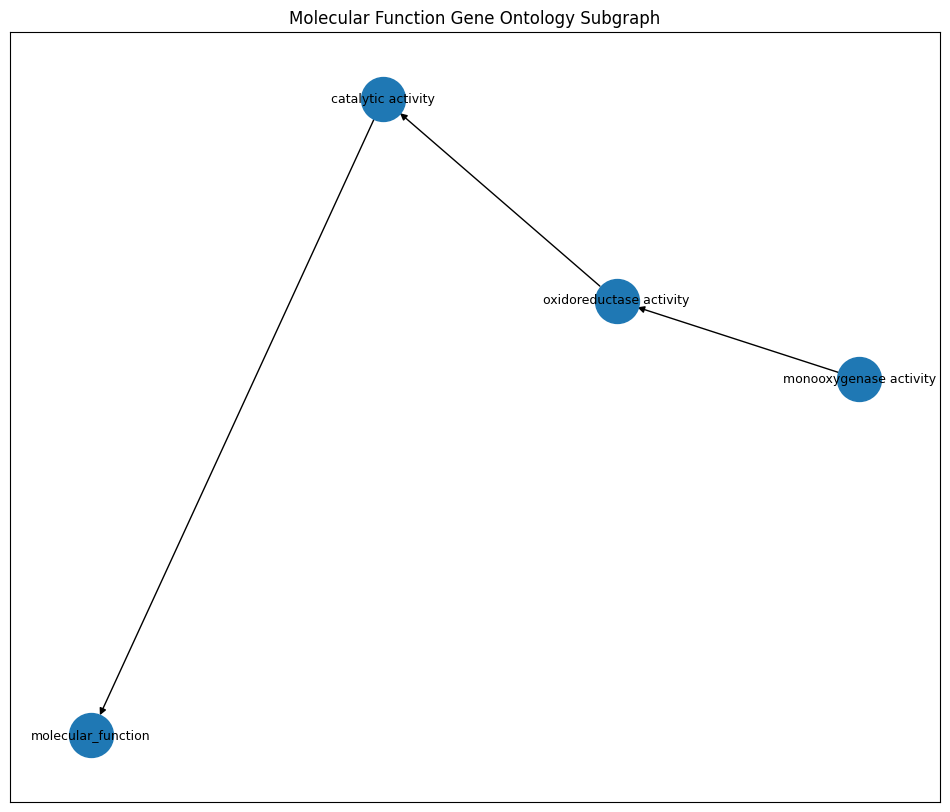

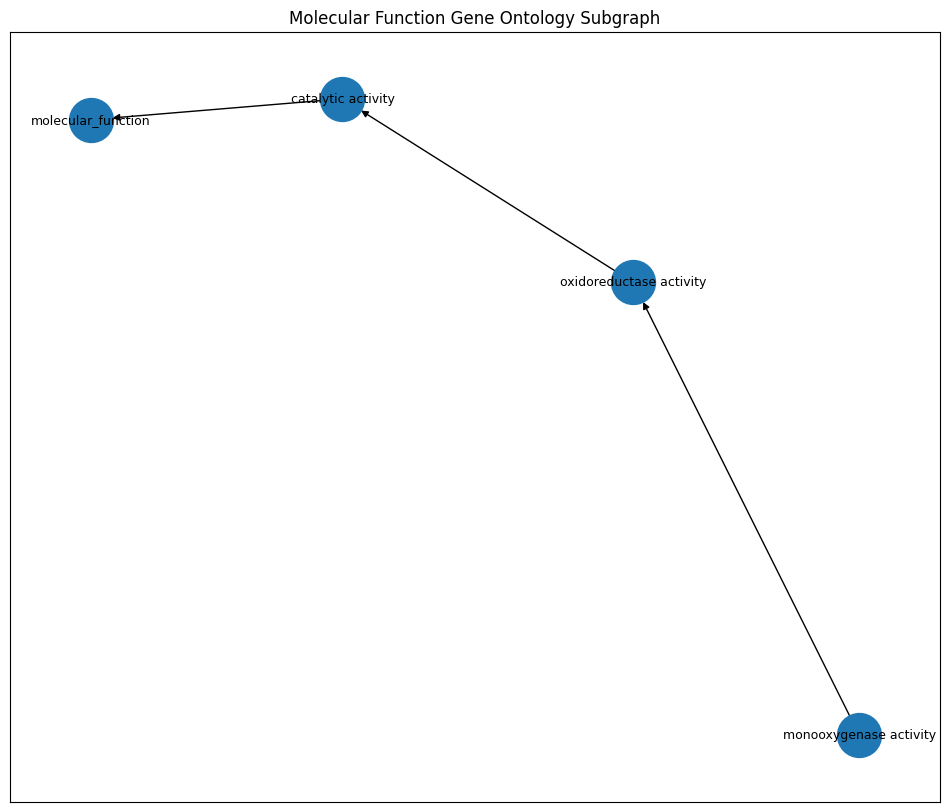

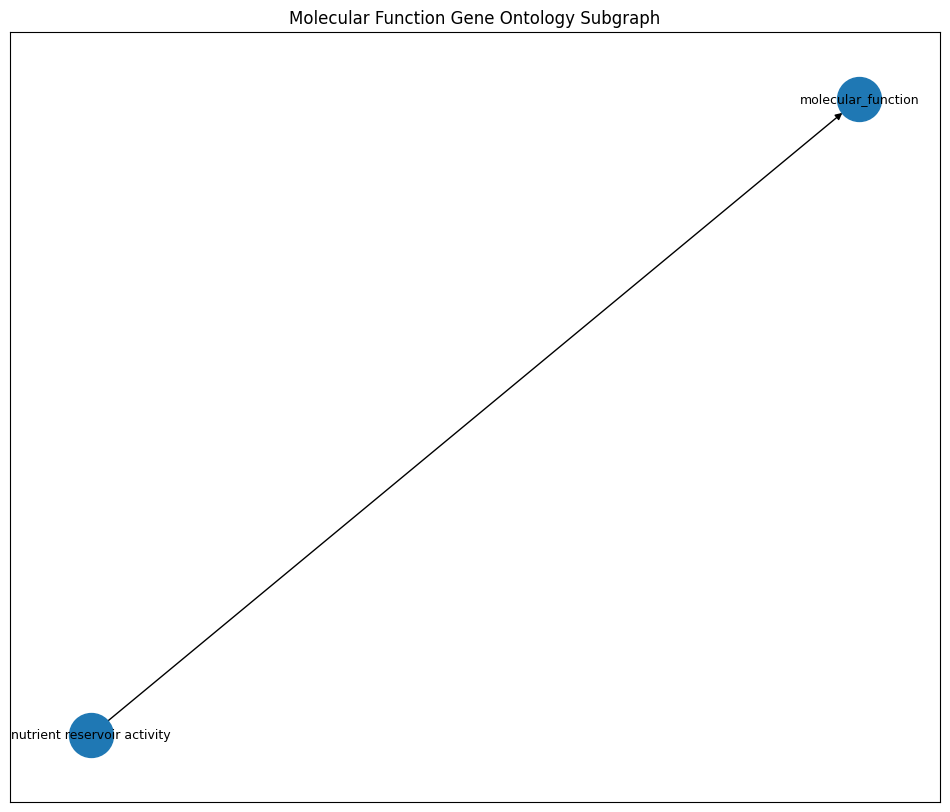

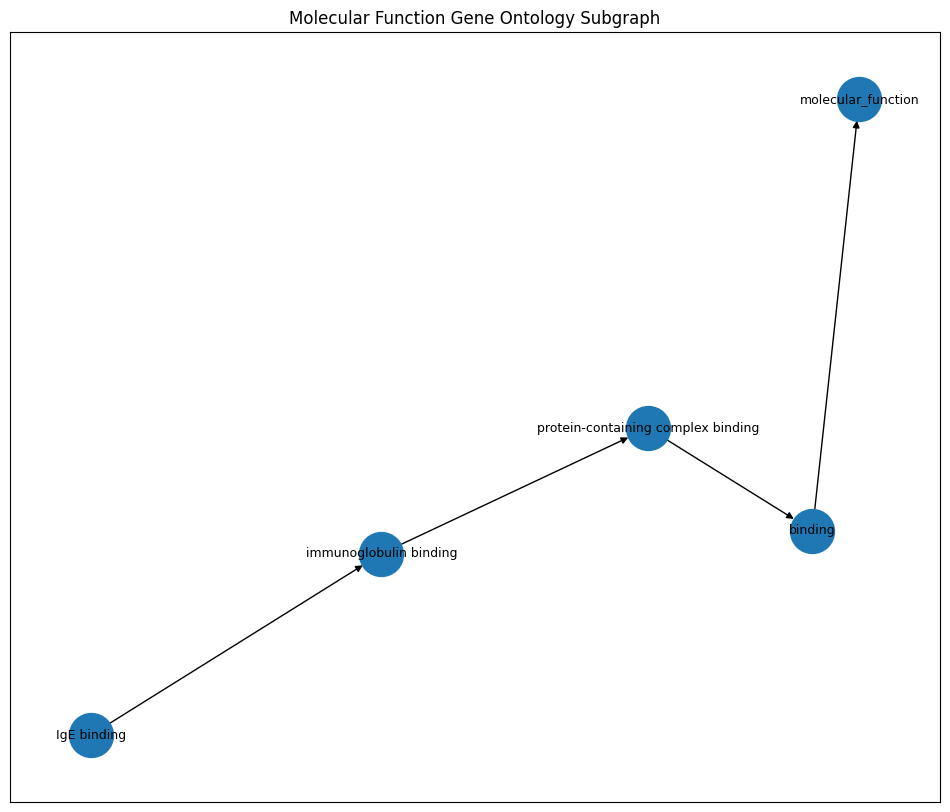

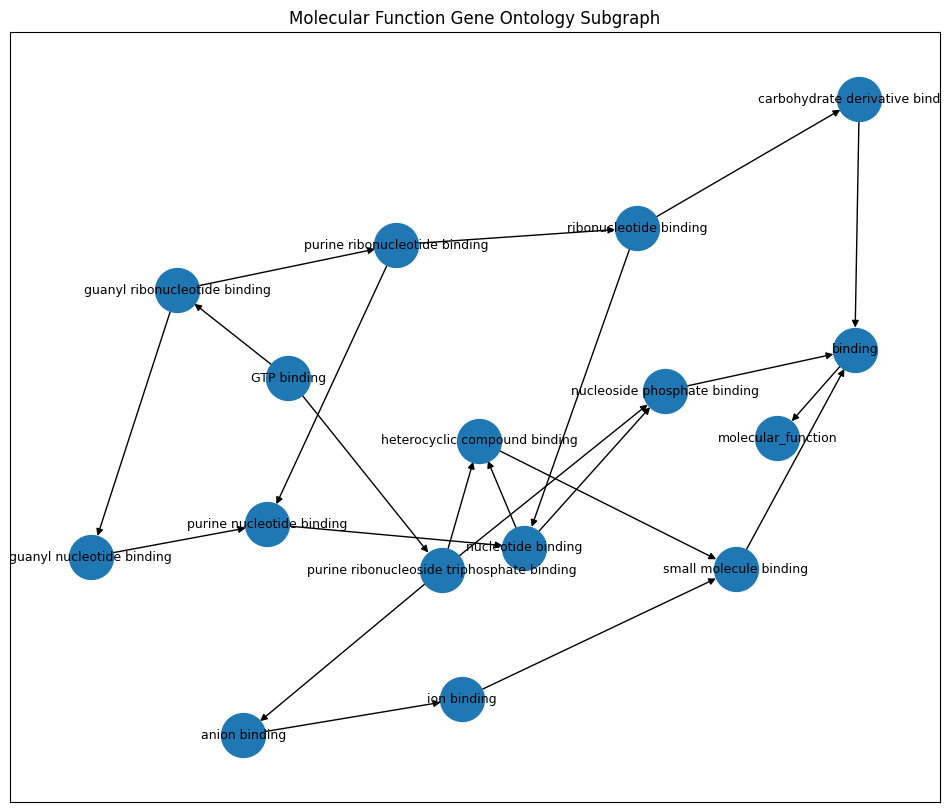

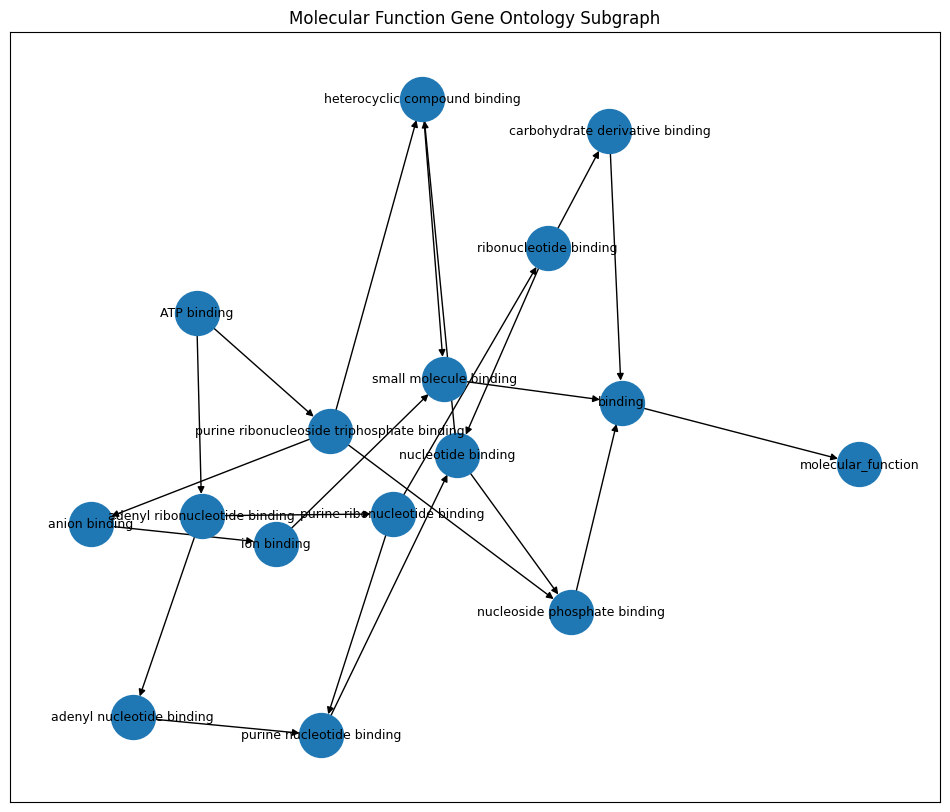

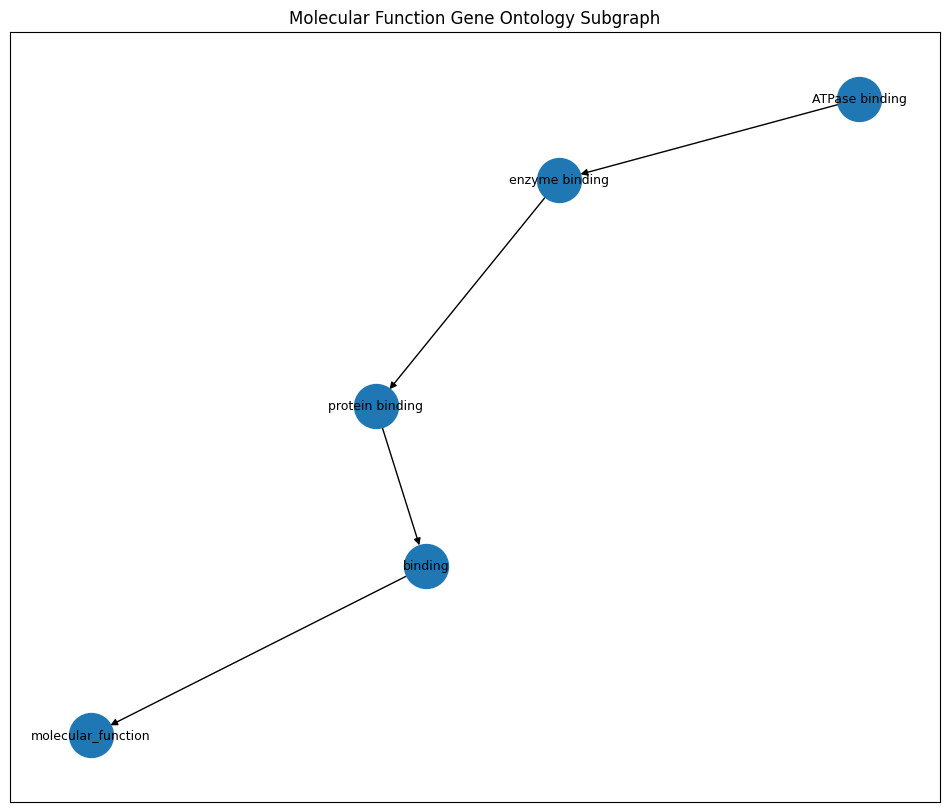

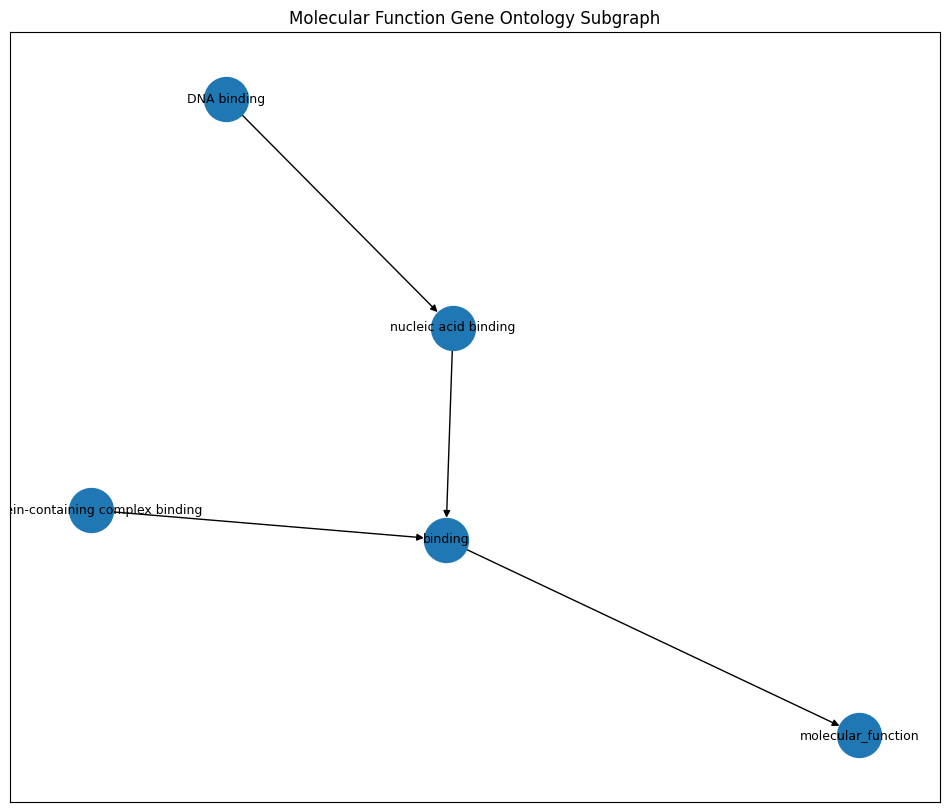

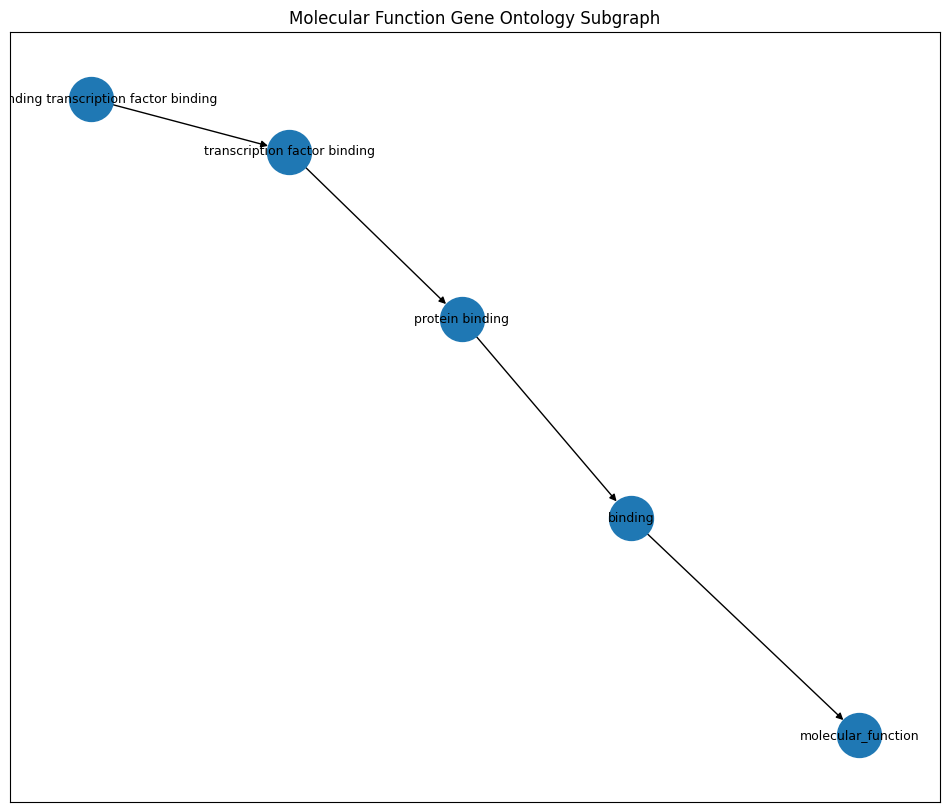

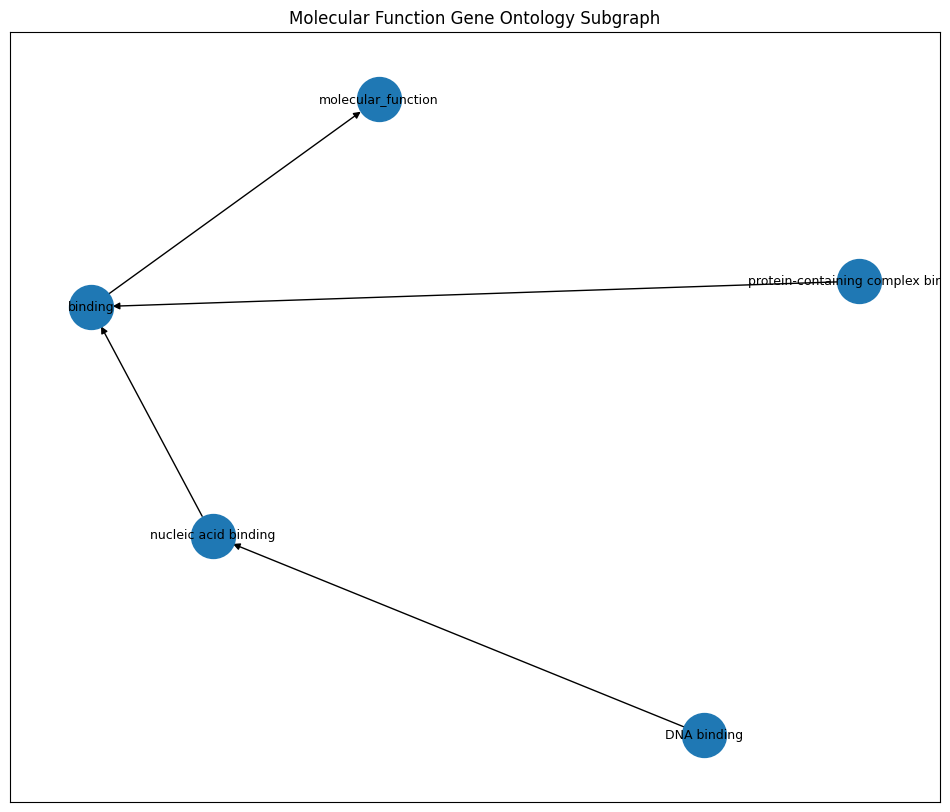

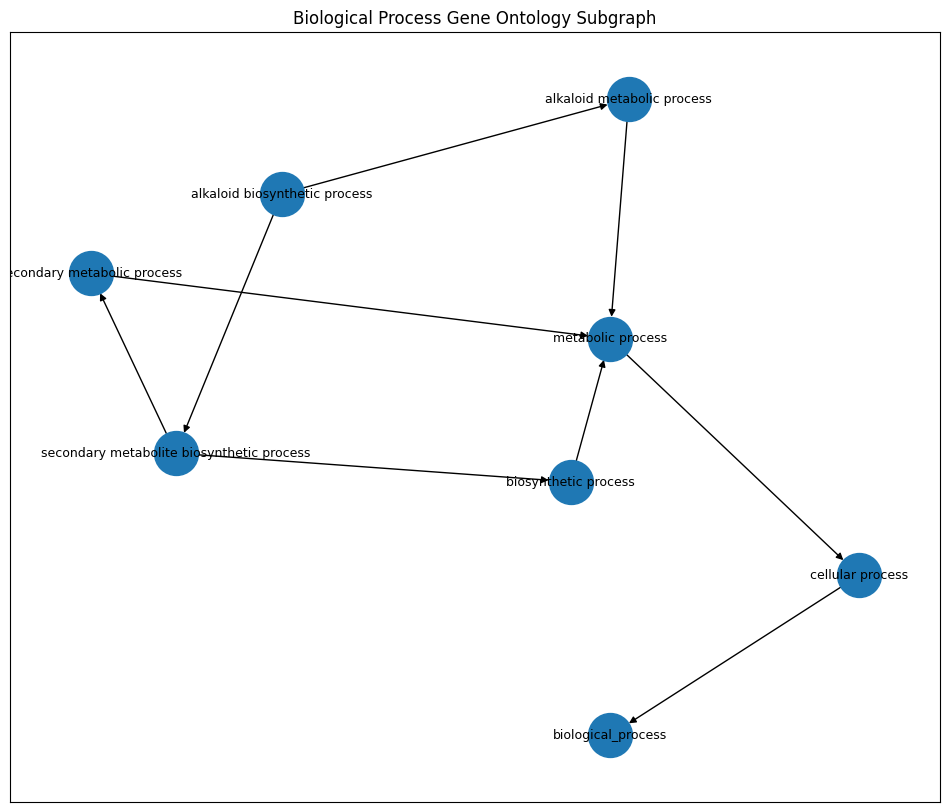

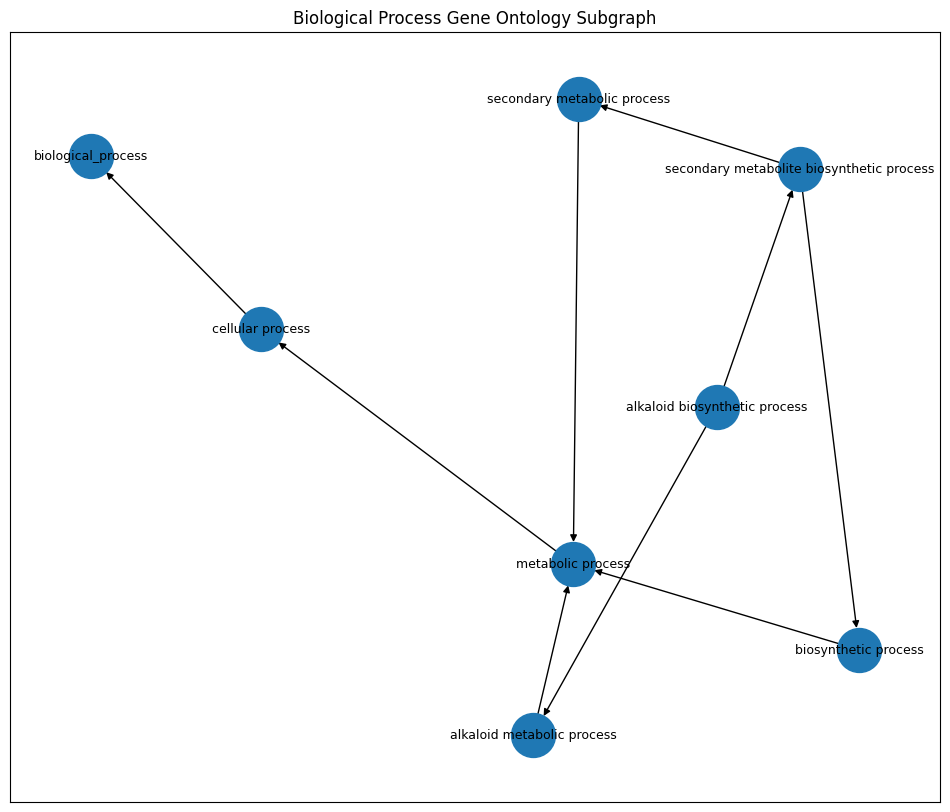

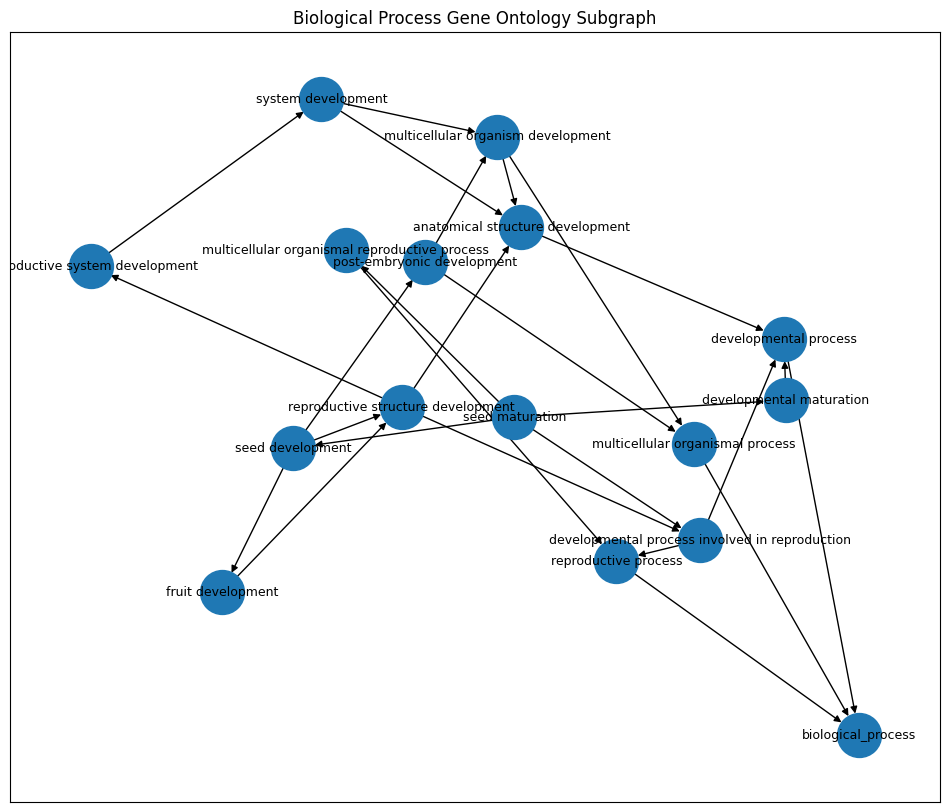

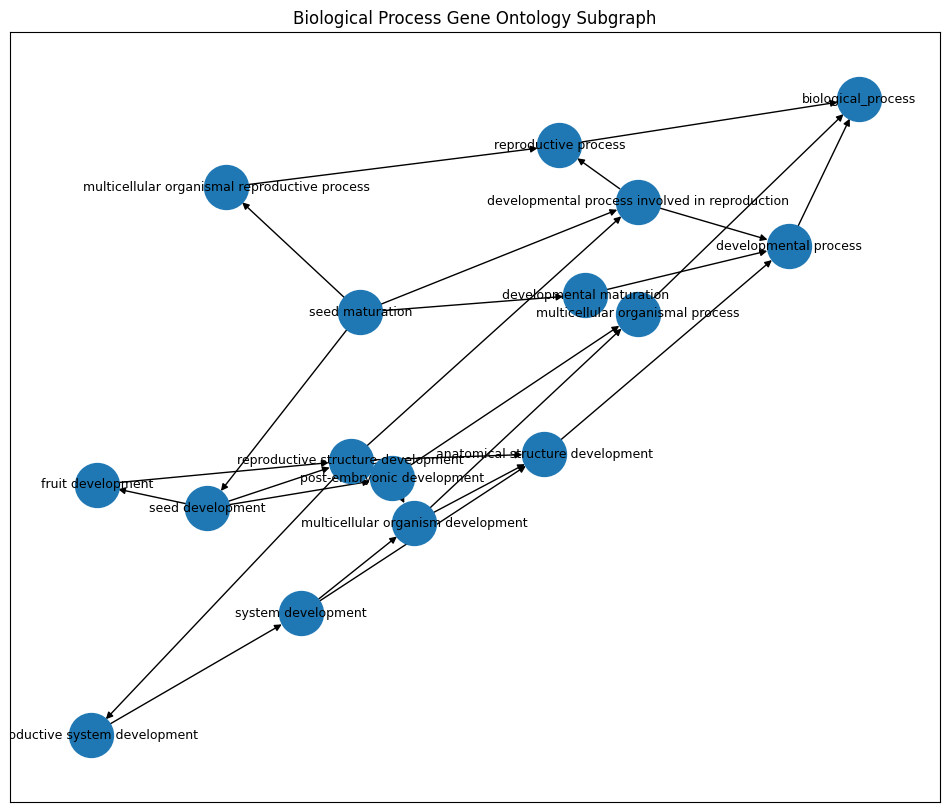

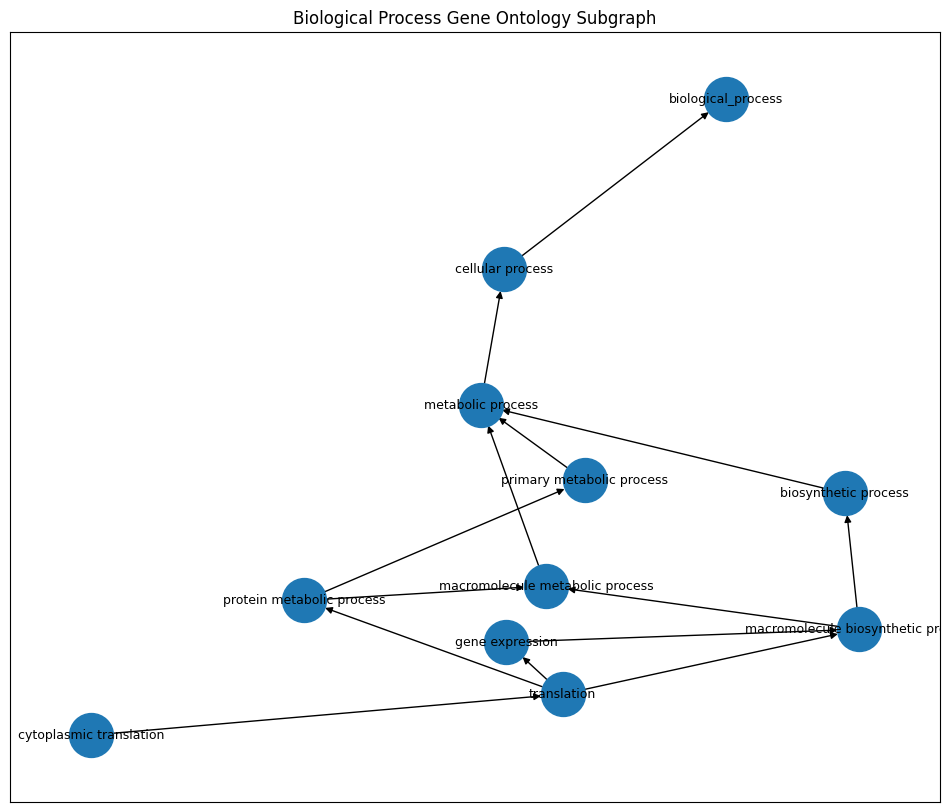

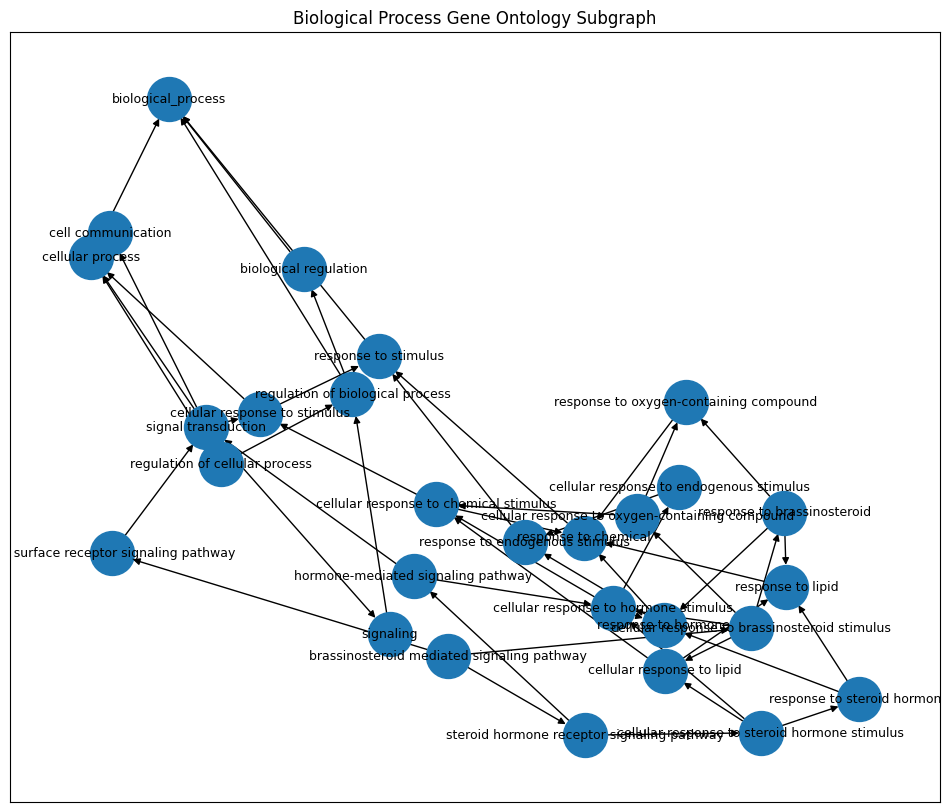

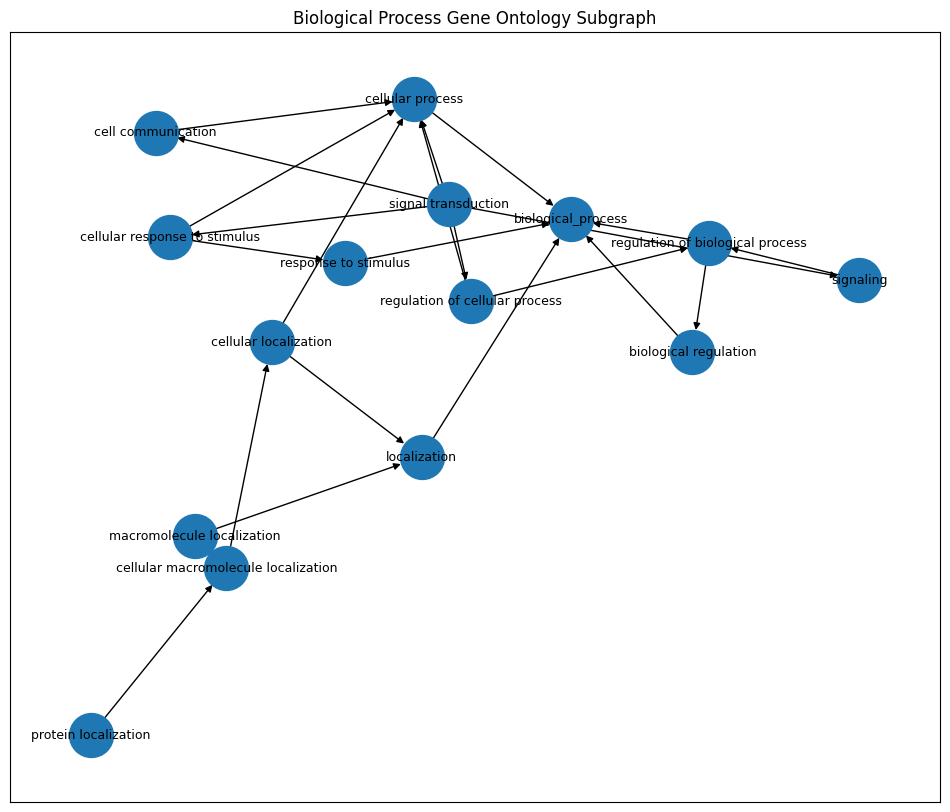

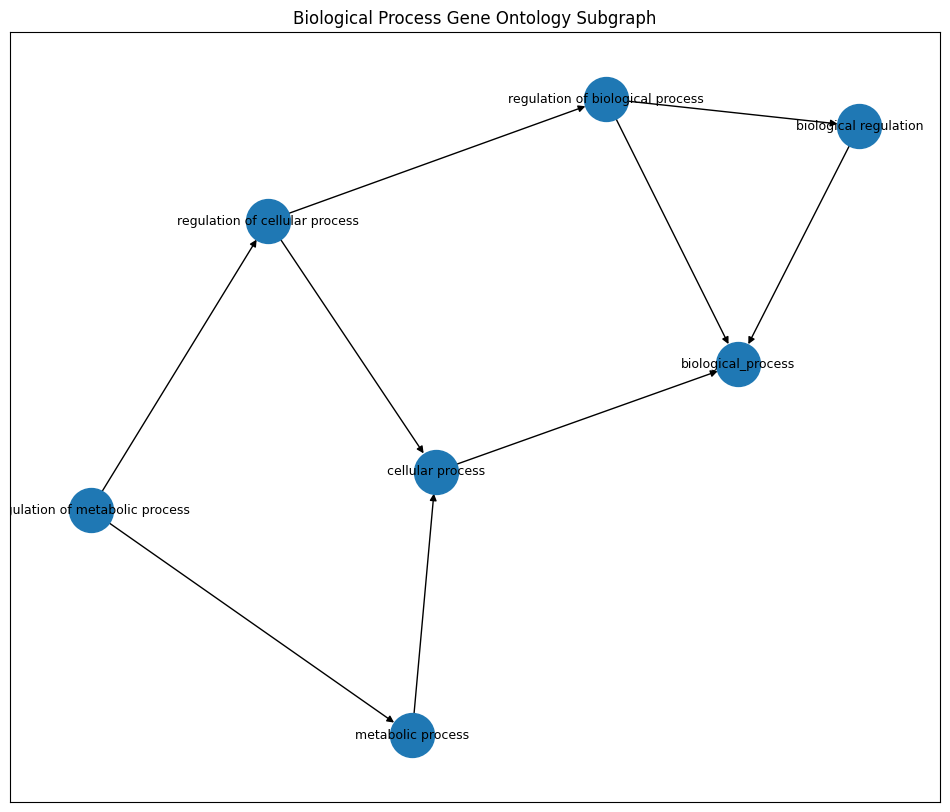

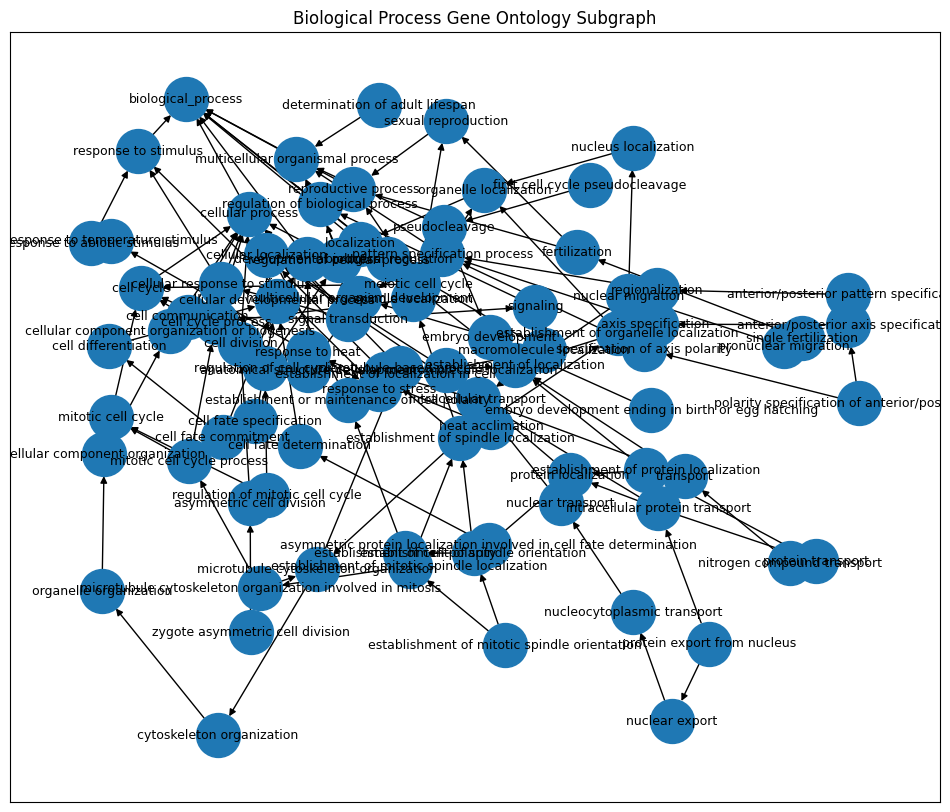

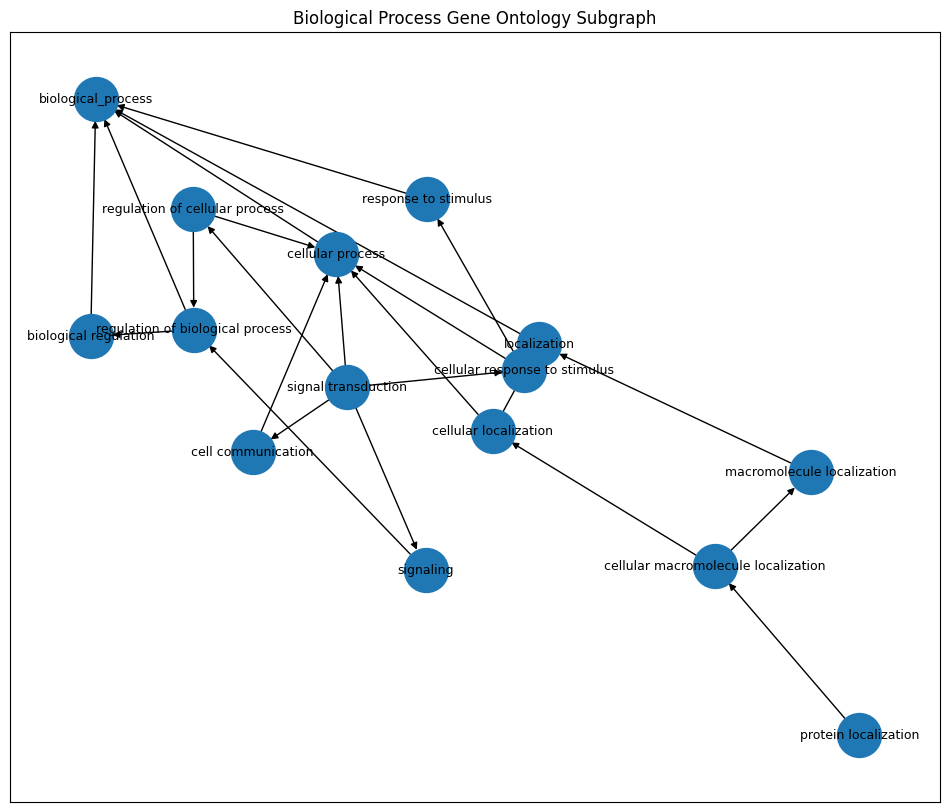

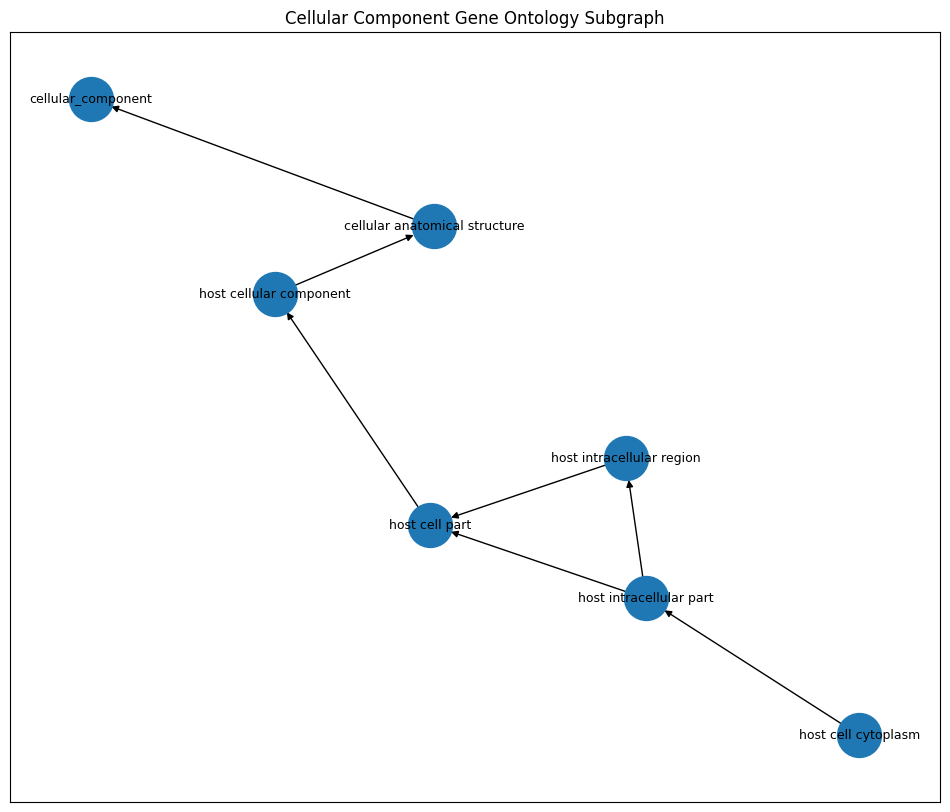

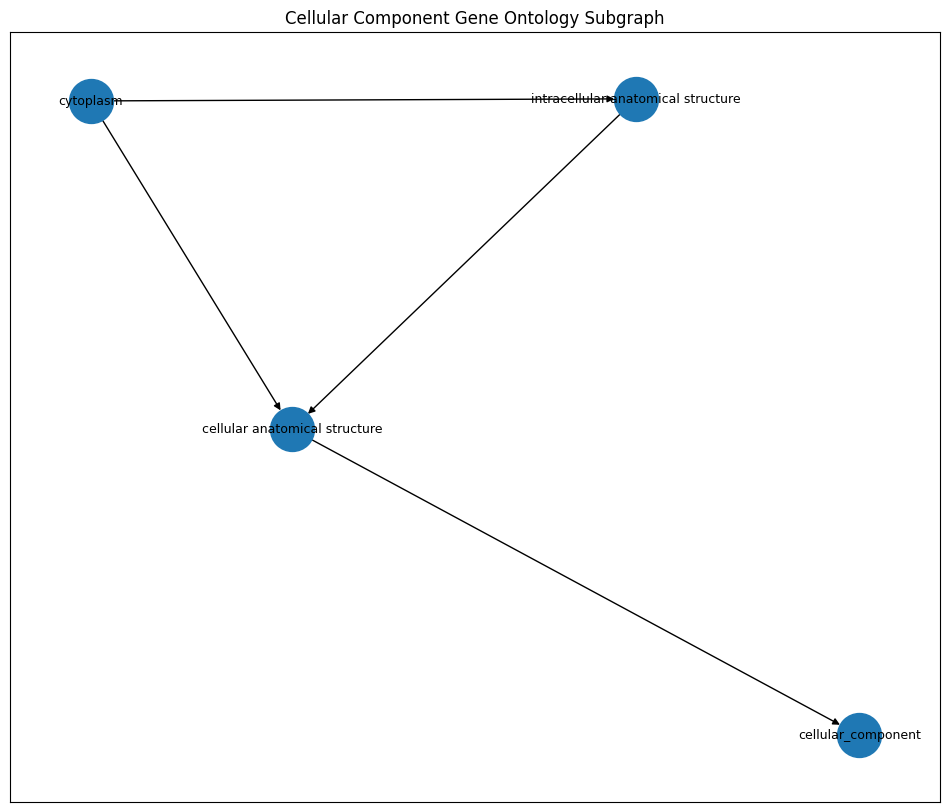

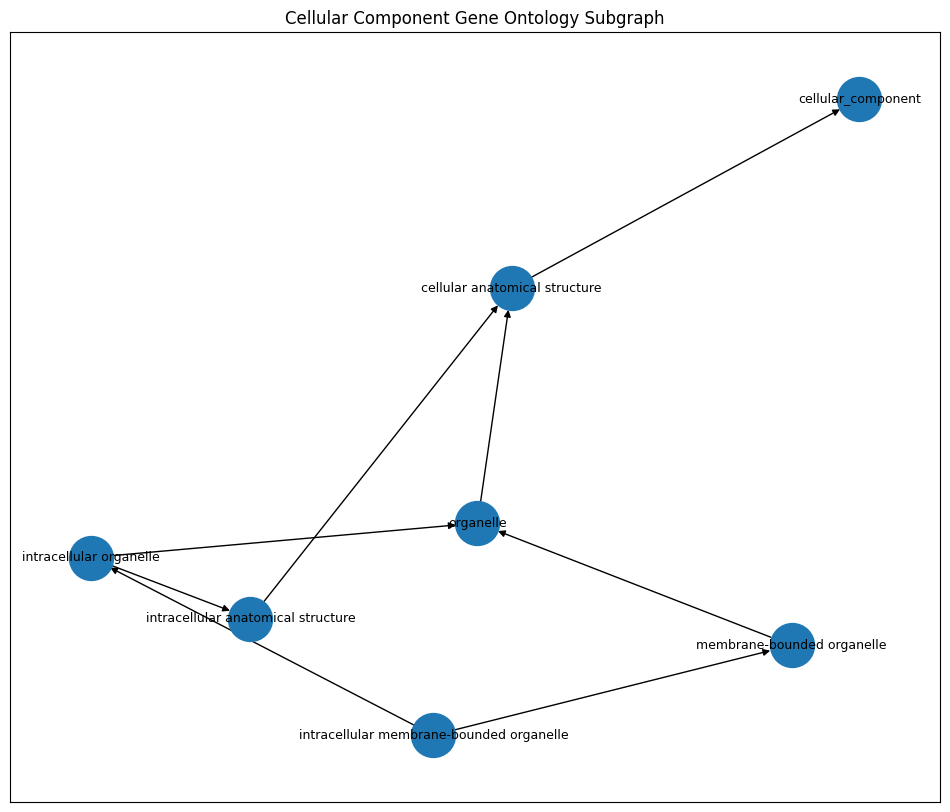

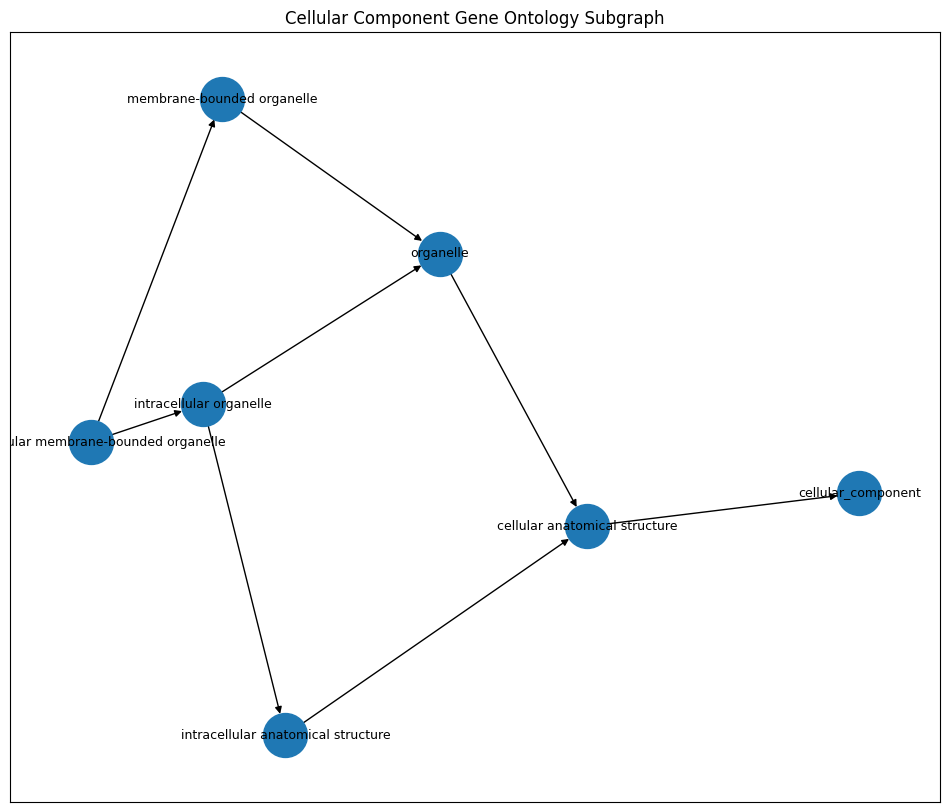

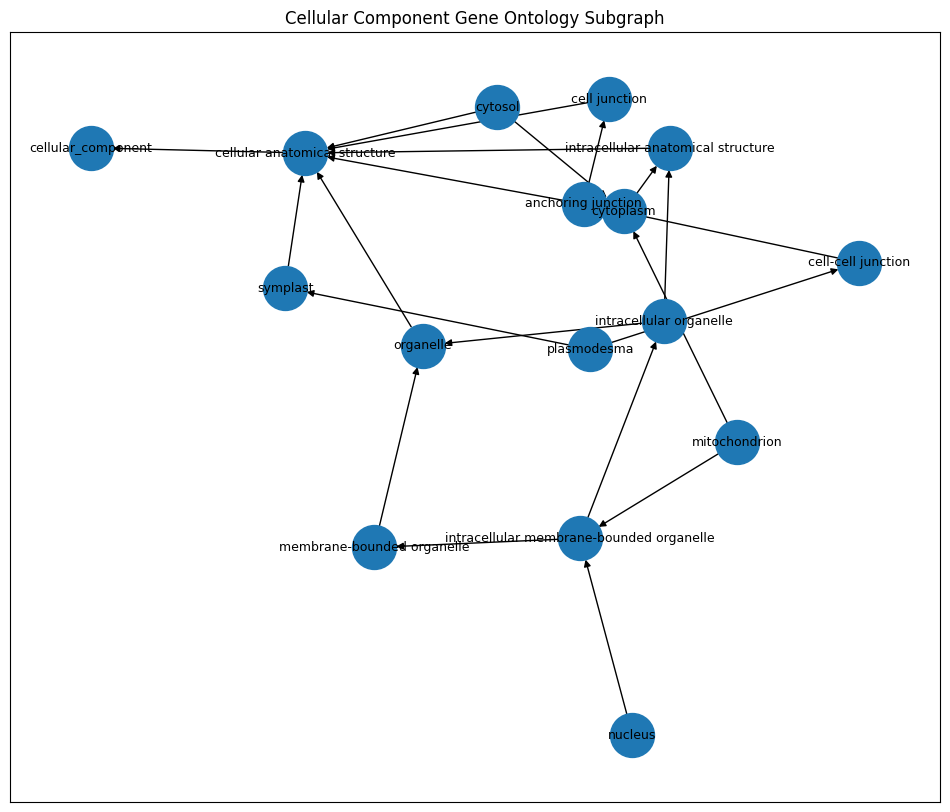

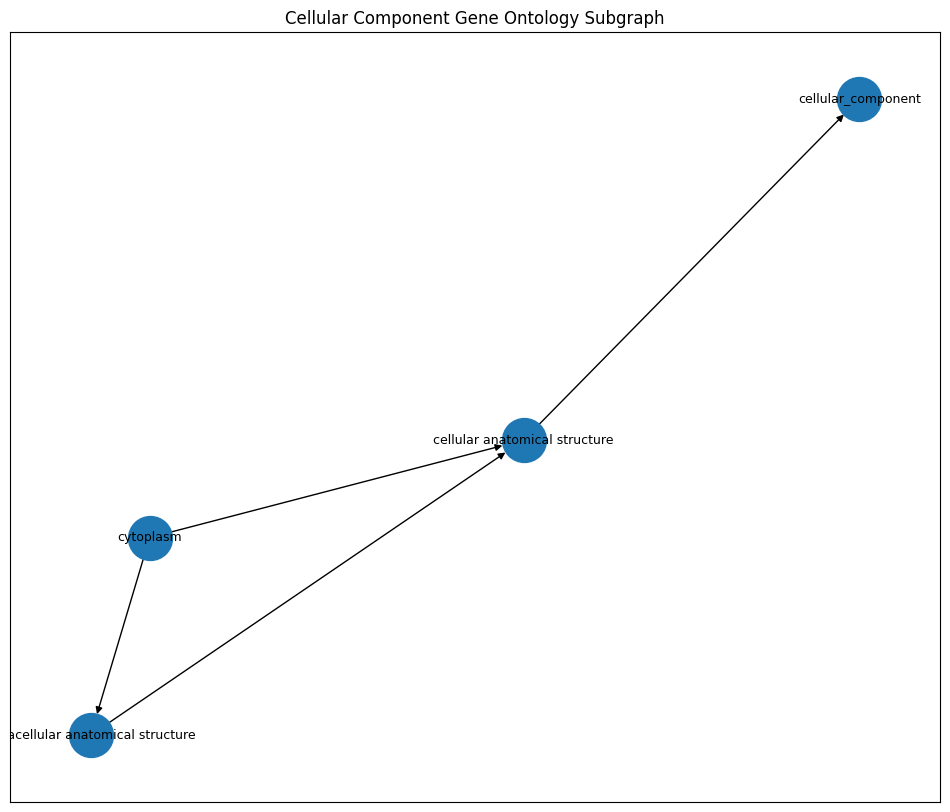

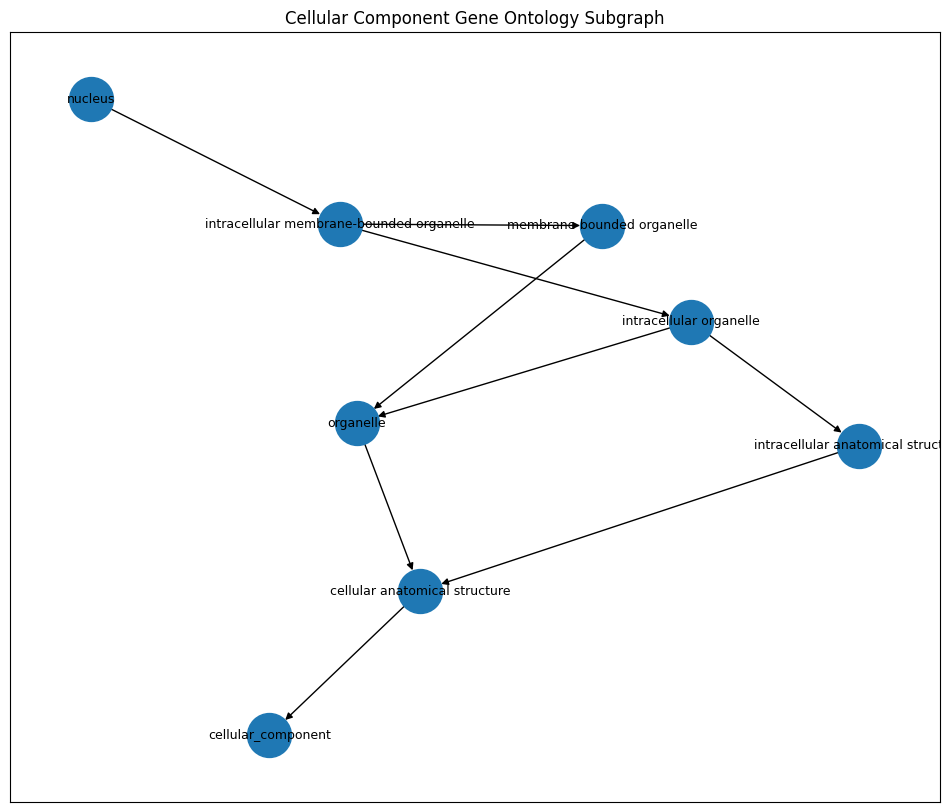

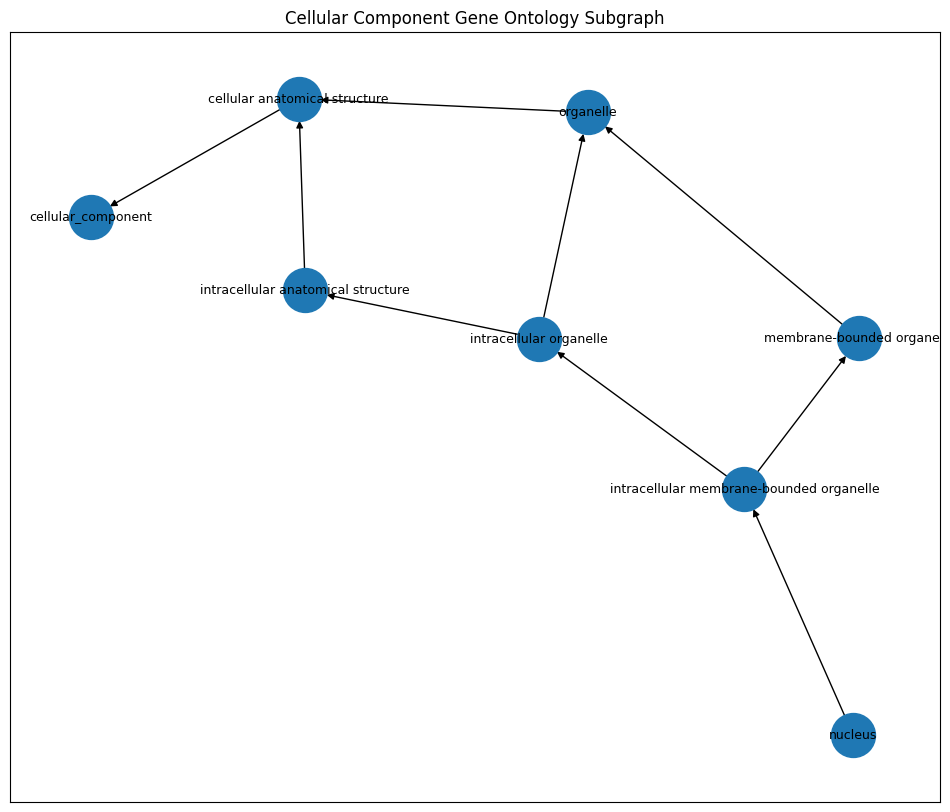

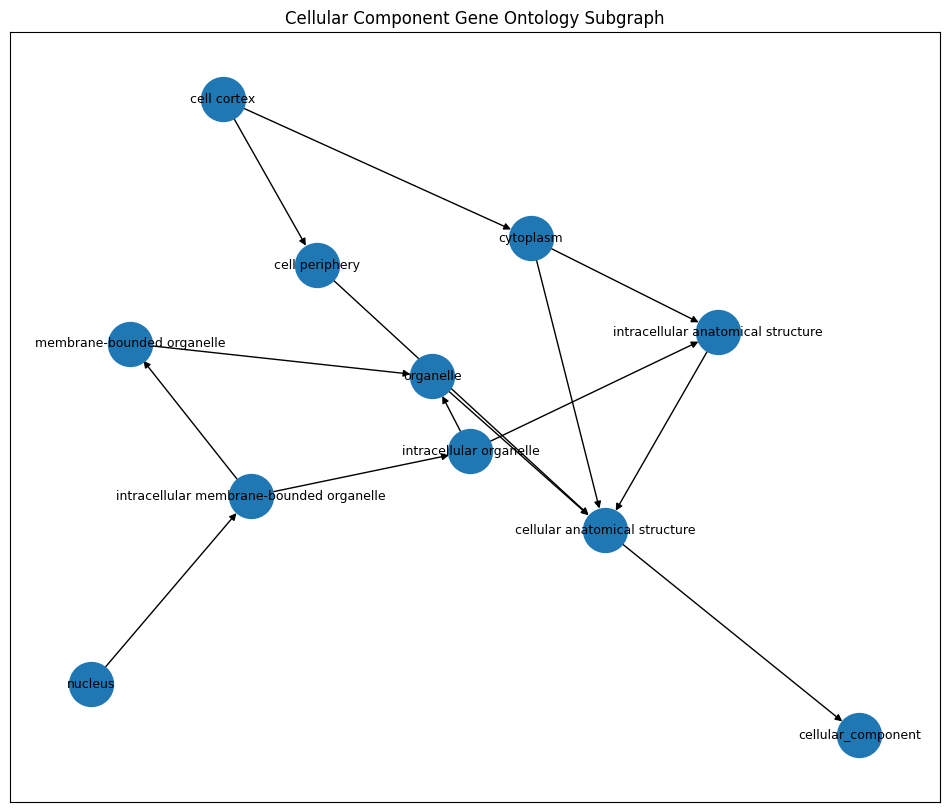

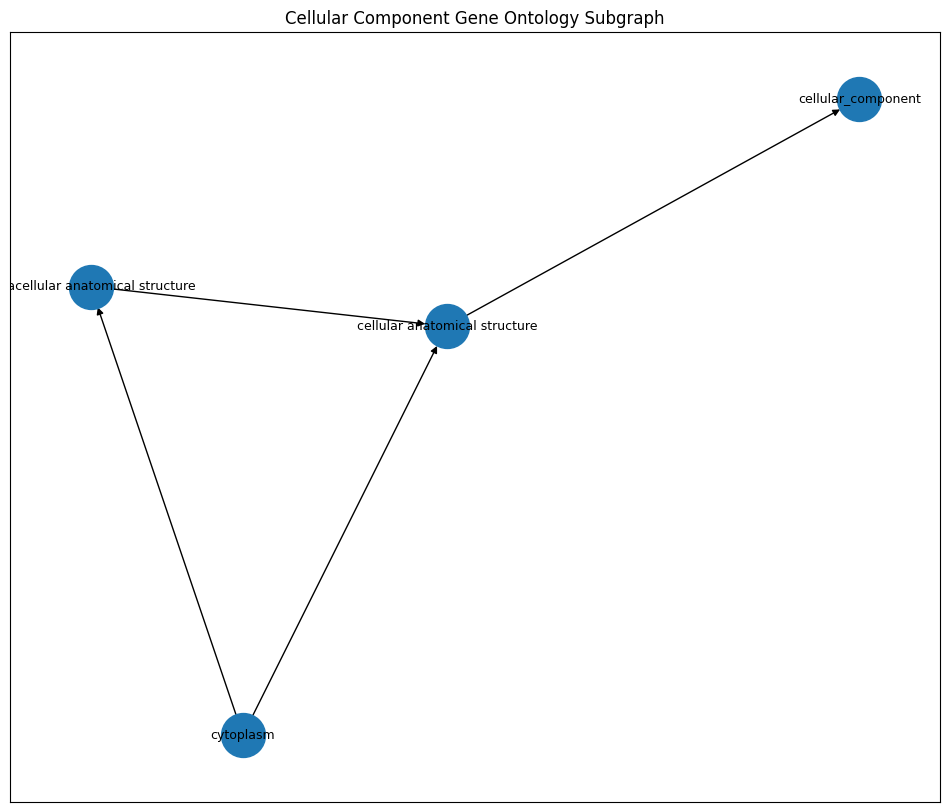

In [3]:
from functools import partial

from itertools import islice


all_dataset_path = "./dataset/all-expanded.jsonl"
mf_dataset_path = "./dataset/mf-expanded.jsonl"
bp_dataset_path = "./dataset/bp-expanded.jsonl"
cc_dataset_path = "./dataset/cc-expanded.jsonl"

plot_subgraph = partial(
    nx.draw_networkx,
    node_size=1000,

    font_size=9,
    with_labels=True,
    arrowsize=10,
)

for name, dataset_path, in [
    ("All", all_dataset_path),
    ("Molecular Function", mf_dataset_path),
    ("Biological Process", bp_dataset_path),
    ("Cellular Component", cc_dataset_path),
]:
    dataset = load_dataset("json", data_files=dataset_path, split="train")

    first_10 = list(islice(dataset, 10))

    for record in first_10:
        subgraph = graph.subgraph(record["go_terms"])

        labels = {
            go_term: f"{data["name"]}"
            for go_term, data in subgraph.nodes(data=True)
        }

        plt.figure(figsize=(12, 10))
        plt.title(f"{name} Gene Ontology Subgraph")

        plot_subgraph(subgraph, labels=labels)

        plt.show()